# Connect to google account

In [1]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [2]:
# 코렙 한글깨짐 방지
!apt -qq -y install fonts-nanum > /dev/null

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name()
# fm._rebuild()


%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# Global Variables

In [3]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/AI_study/1. Machine Learning/3. Supervised Learning/original data/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0220_eda_model_test.csv'
args.save_results = args.default_path+"result/model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 42
args.results = []
with open(args.save_results, 'r') as file:
    args.results = json.load(file)

args.results

[{'model': 'modelV4',
  'score_tr': 0.9547581903,
  'score_te': 0.8327272727,
  'auc_te': 0.916020018,
  'len_features': 10,
  'feaute_importances': ['fare',
   'age',
   'sibsp',
   'pclass',
   'embarked_S',
   'gender_female',
   'parch',
   'embarked_C',
   'embarked_Q',
   'gender_male'],
  'create_dt': '0217'}]

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- Sex:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [4]:
import numpy as np
import pandas as pd

# !pip uninstall -y scikit-learn joblib
!pip install pycaret[full]

# # check installed version
# import pycaret
# pycaret.__version__

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 657.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of selenium to determine which version is compatible with other requirements. This

In [5]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [6]:
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [7]:
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.shape

(916, 11)

In [8]:
ori_test.set_index(['passengerid'], inplace=True)
ori_test.shape

(393, 10)

# ModelV4

In [9]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 11), (393, 10))

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train, test = train_test_split(ori_tr, test_size=0.3, stratify=ori_tr['survived'], random_state=args.random_state)

train.shape, test.shape

((641, 11), (275, 11))

- cabin: 학습에 도움이 안됨!!, 삭제 필요!!

In [12]:
train.drop('cabin', axis=1, inplace=True)
test.drop('cabin', axis=1, inplace=True)
ori_te.drop('cabin', axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 9))

## Feature Extraction with EDA

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 539 to 636
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  641 non-null    int64  
 1   pclass    641 non-null    int64  
 2   name      641 non-null    object 
 3   gender    641 non-null    object 
 4   age       523 non-null    float64
 5   sibsp     641 non-null    int64  
 6   parch     641 non-null    int64  
 7   ticket    641 non-null    object 
 8   fare      641 non-null    float64
 9   embarked  641 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 55.1+ KB


### continous features

In [14]:
continous_cols = ['age', 'fare'] + ['survived']

train[continous_cols].describe()

age        fare    survived
count  523.000000  641.000000  641.000000
mean    29.853576   31.941796    0.377535
std     14.536210   47.068732    0.485149
min      0.170000    0.000000    0.000000
25%     21.000000    7.925000    0.000000
50%     28.000000   14.500000    0.000000
75%     38.000000   30.000000    1.000000
max     80.000000  512.329200    1.000000

In [15]:
train[continous_cols].corr()

age      fare  survived
age       1.000000  0.151860 -0.040994
fare      0.151860  1.000000  0.176041
survived -0.040994  0.176041  1.000000

age

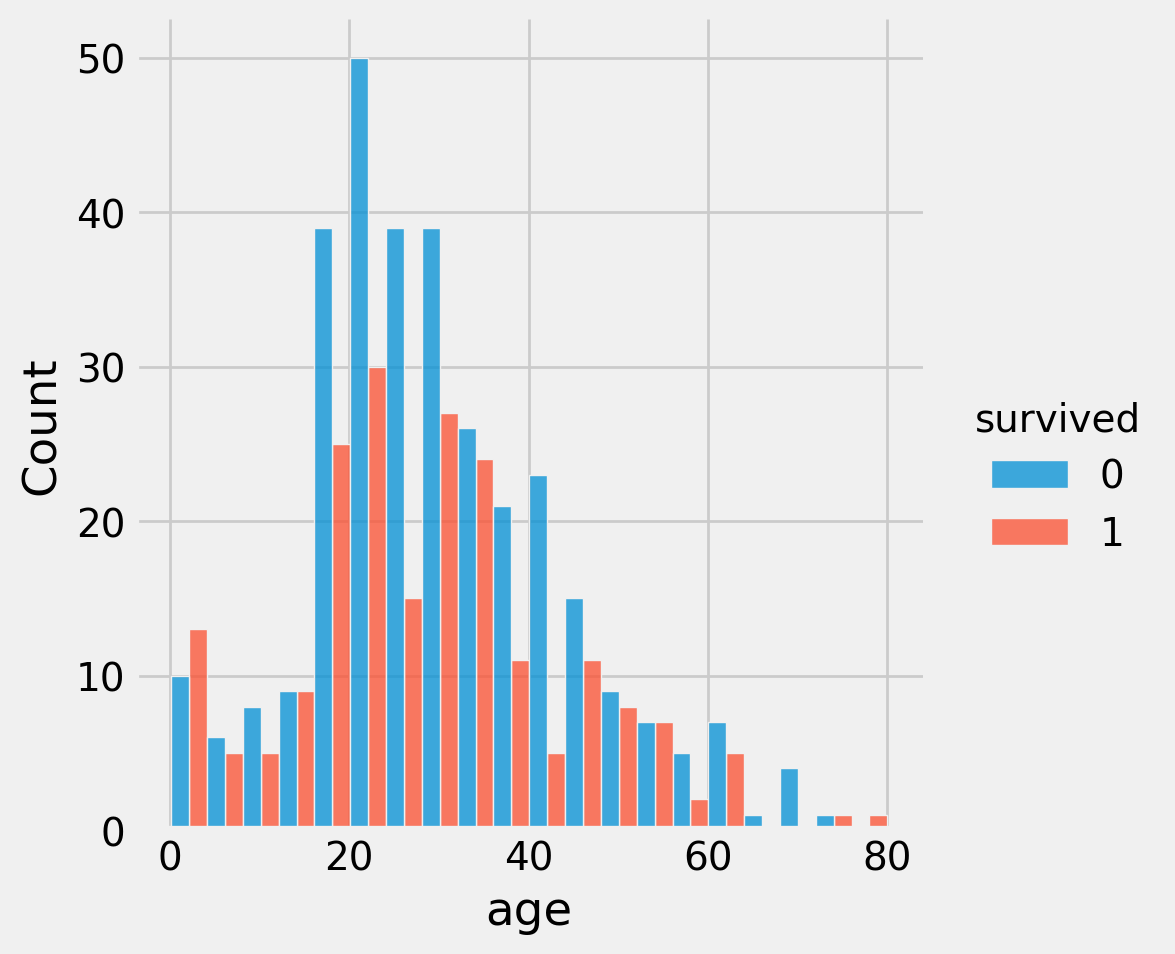

In [16]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [17]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.6

In [18]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.3125

In [19]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3795180722891566

add infant

In [20]:
def add_infant(age):
  result = 0
  try:
    if age <= 5:
      result = 1
  except:
    pass
  return result

train['infant'] = train['age'].map(lambda x: add_infant(x))
test['infant'] = test['age'].map(lambda x: add_infant(x))
ori_te['infant'] = ori_te['age'].map(lambda x: add_infant(x))

print(f"{train['infant'].nunique()} / \n {train['infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

2 / 
 [0 1] 



((641, 11), (275, 11), (393, 10))

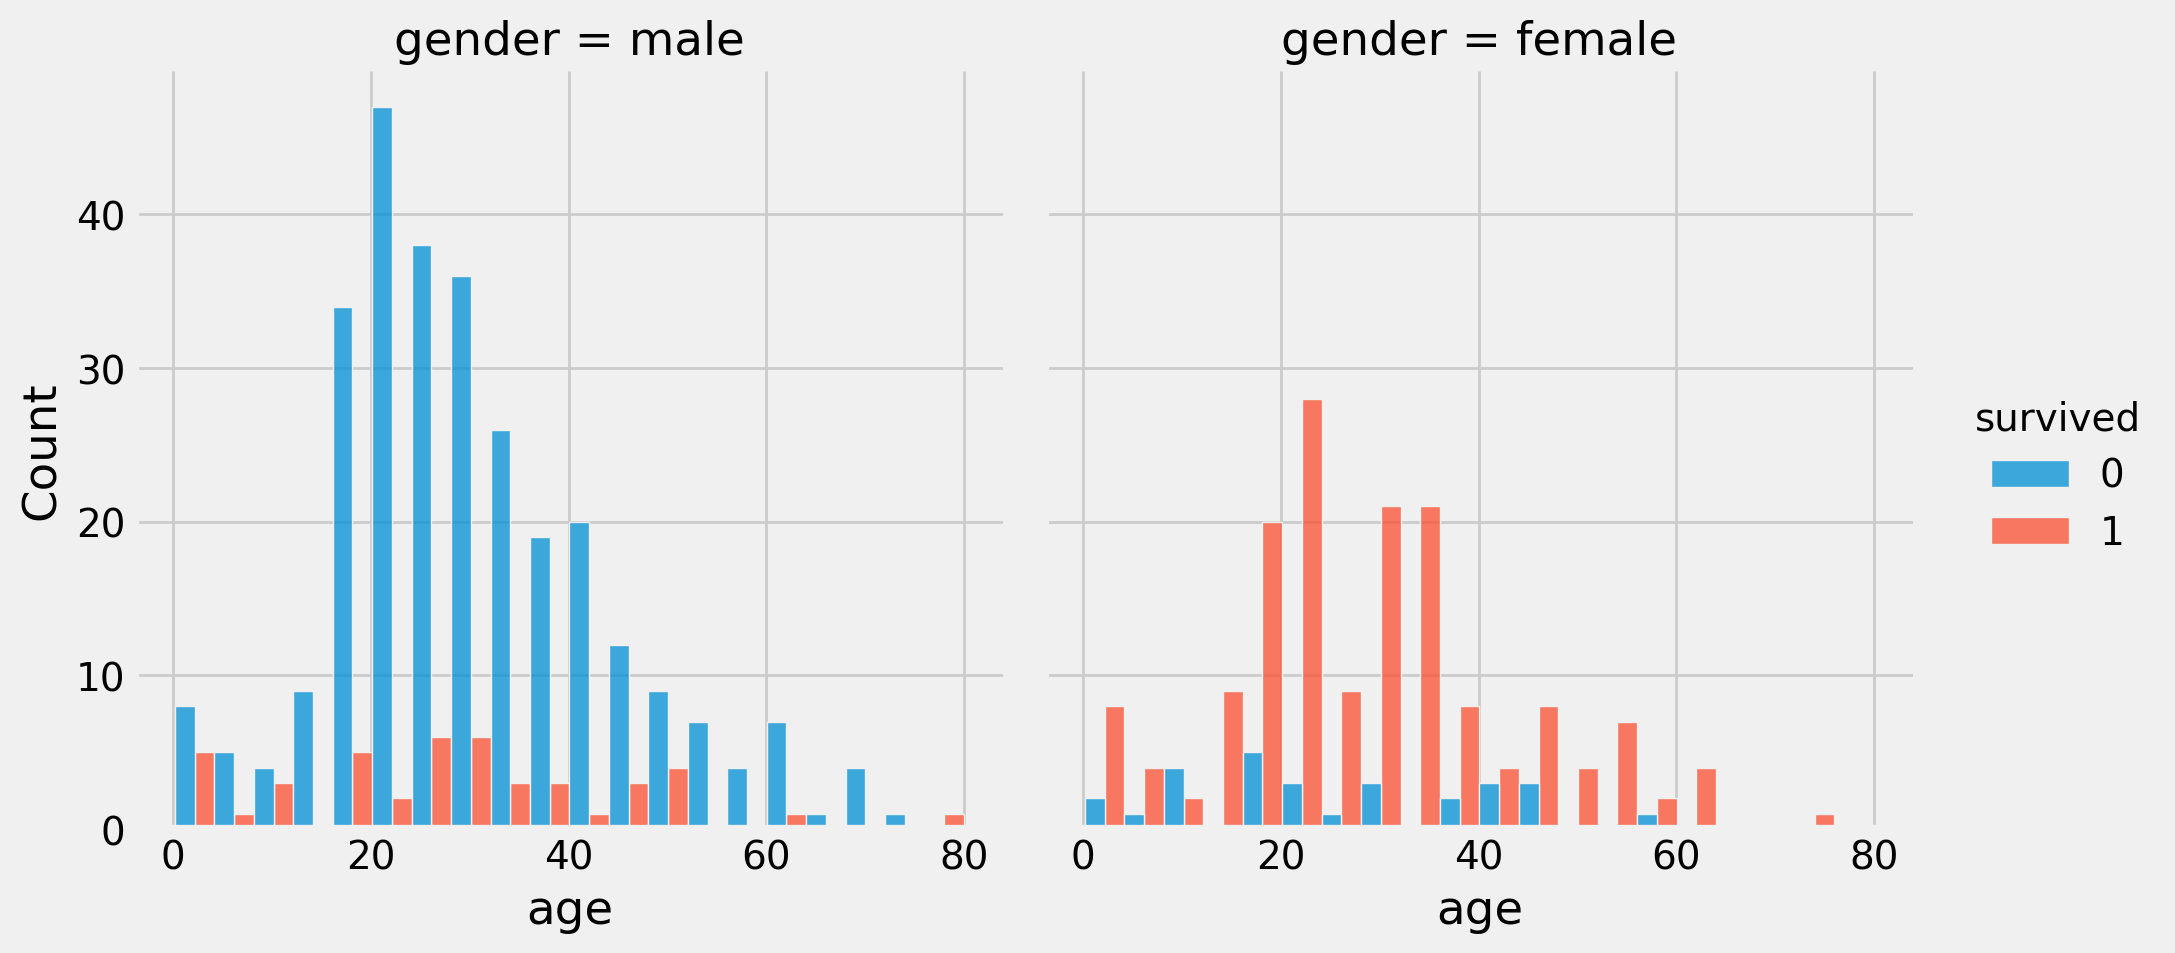

In [21]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

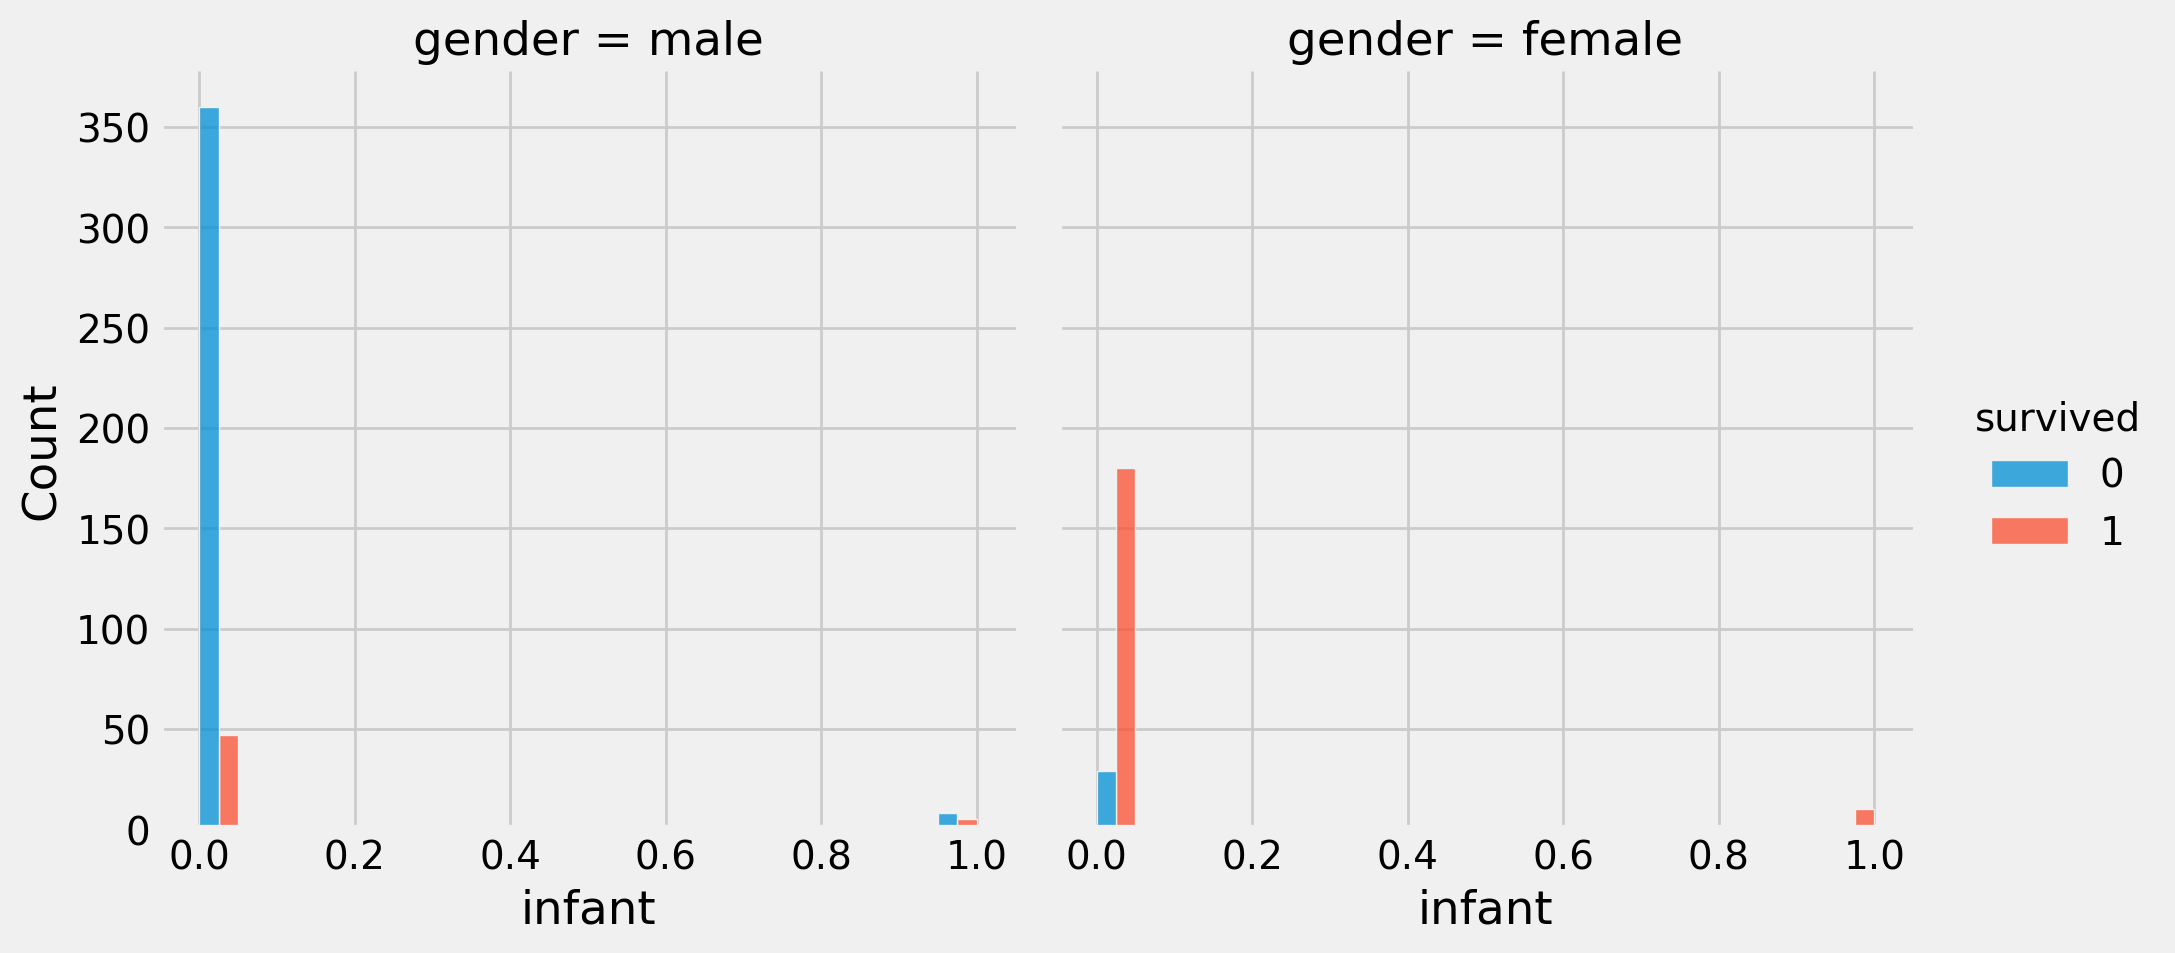

In [22]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

add gender_infant

In [23]:
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"{train['gender_infant'].nunique()} / \n {train['gender_infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

4 / 
 ['male_0' 'female_0' 'female_1' 'male_1'] 



((641, 12), (275, 12), (393, 11))

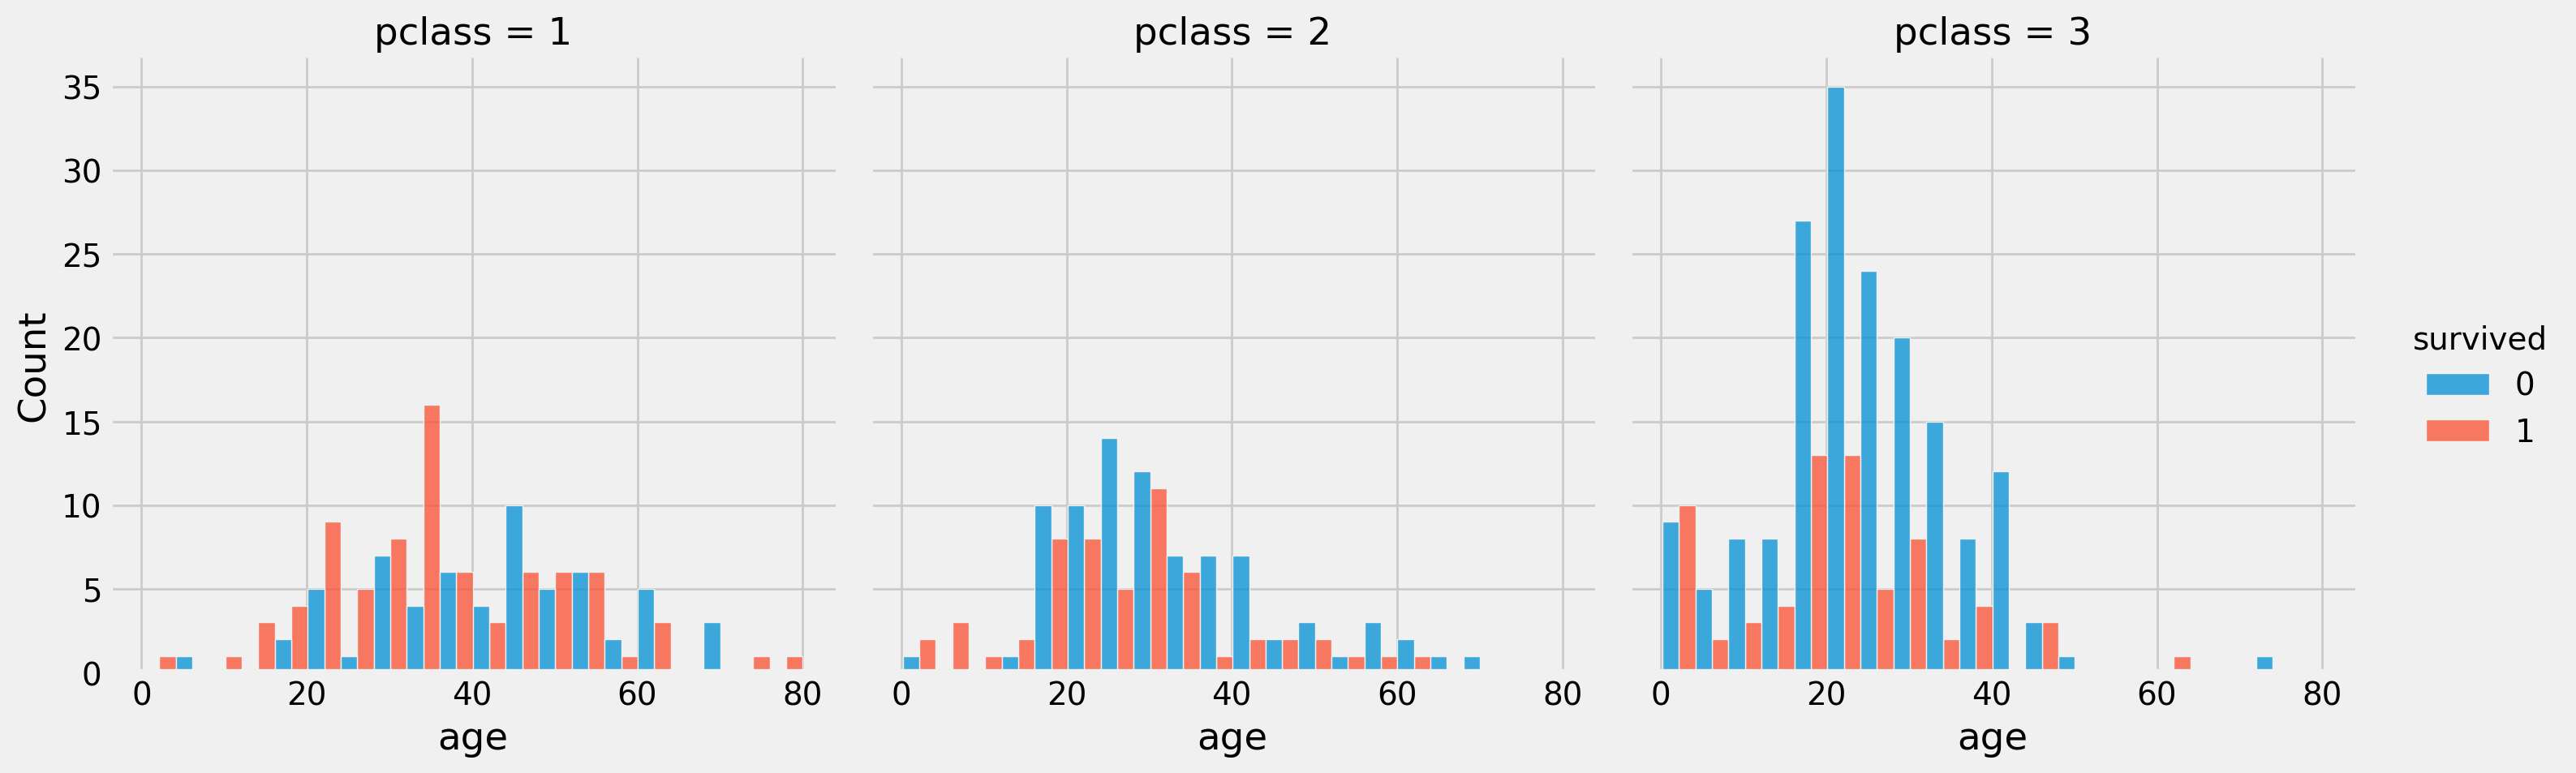

In [24]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass")

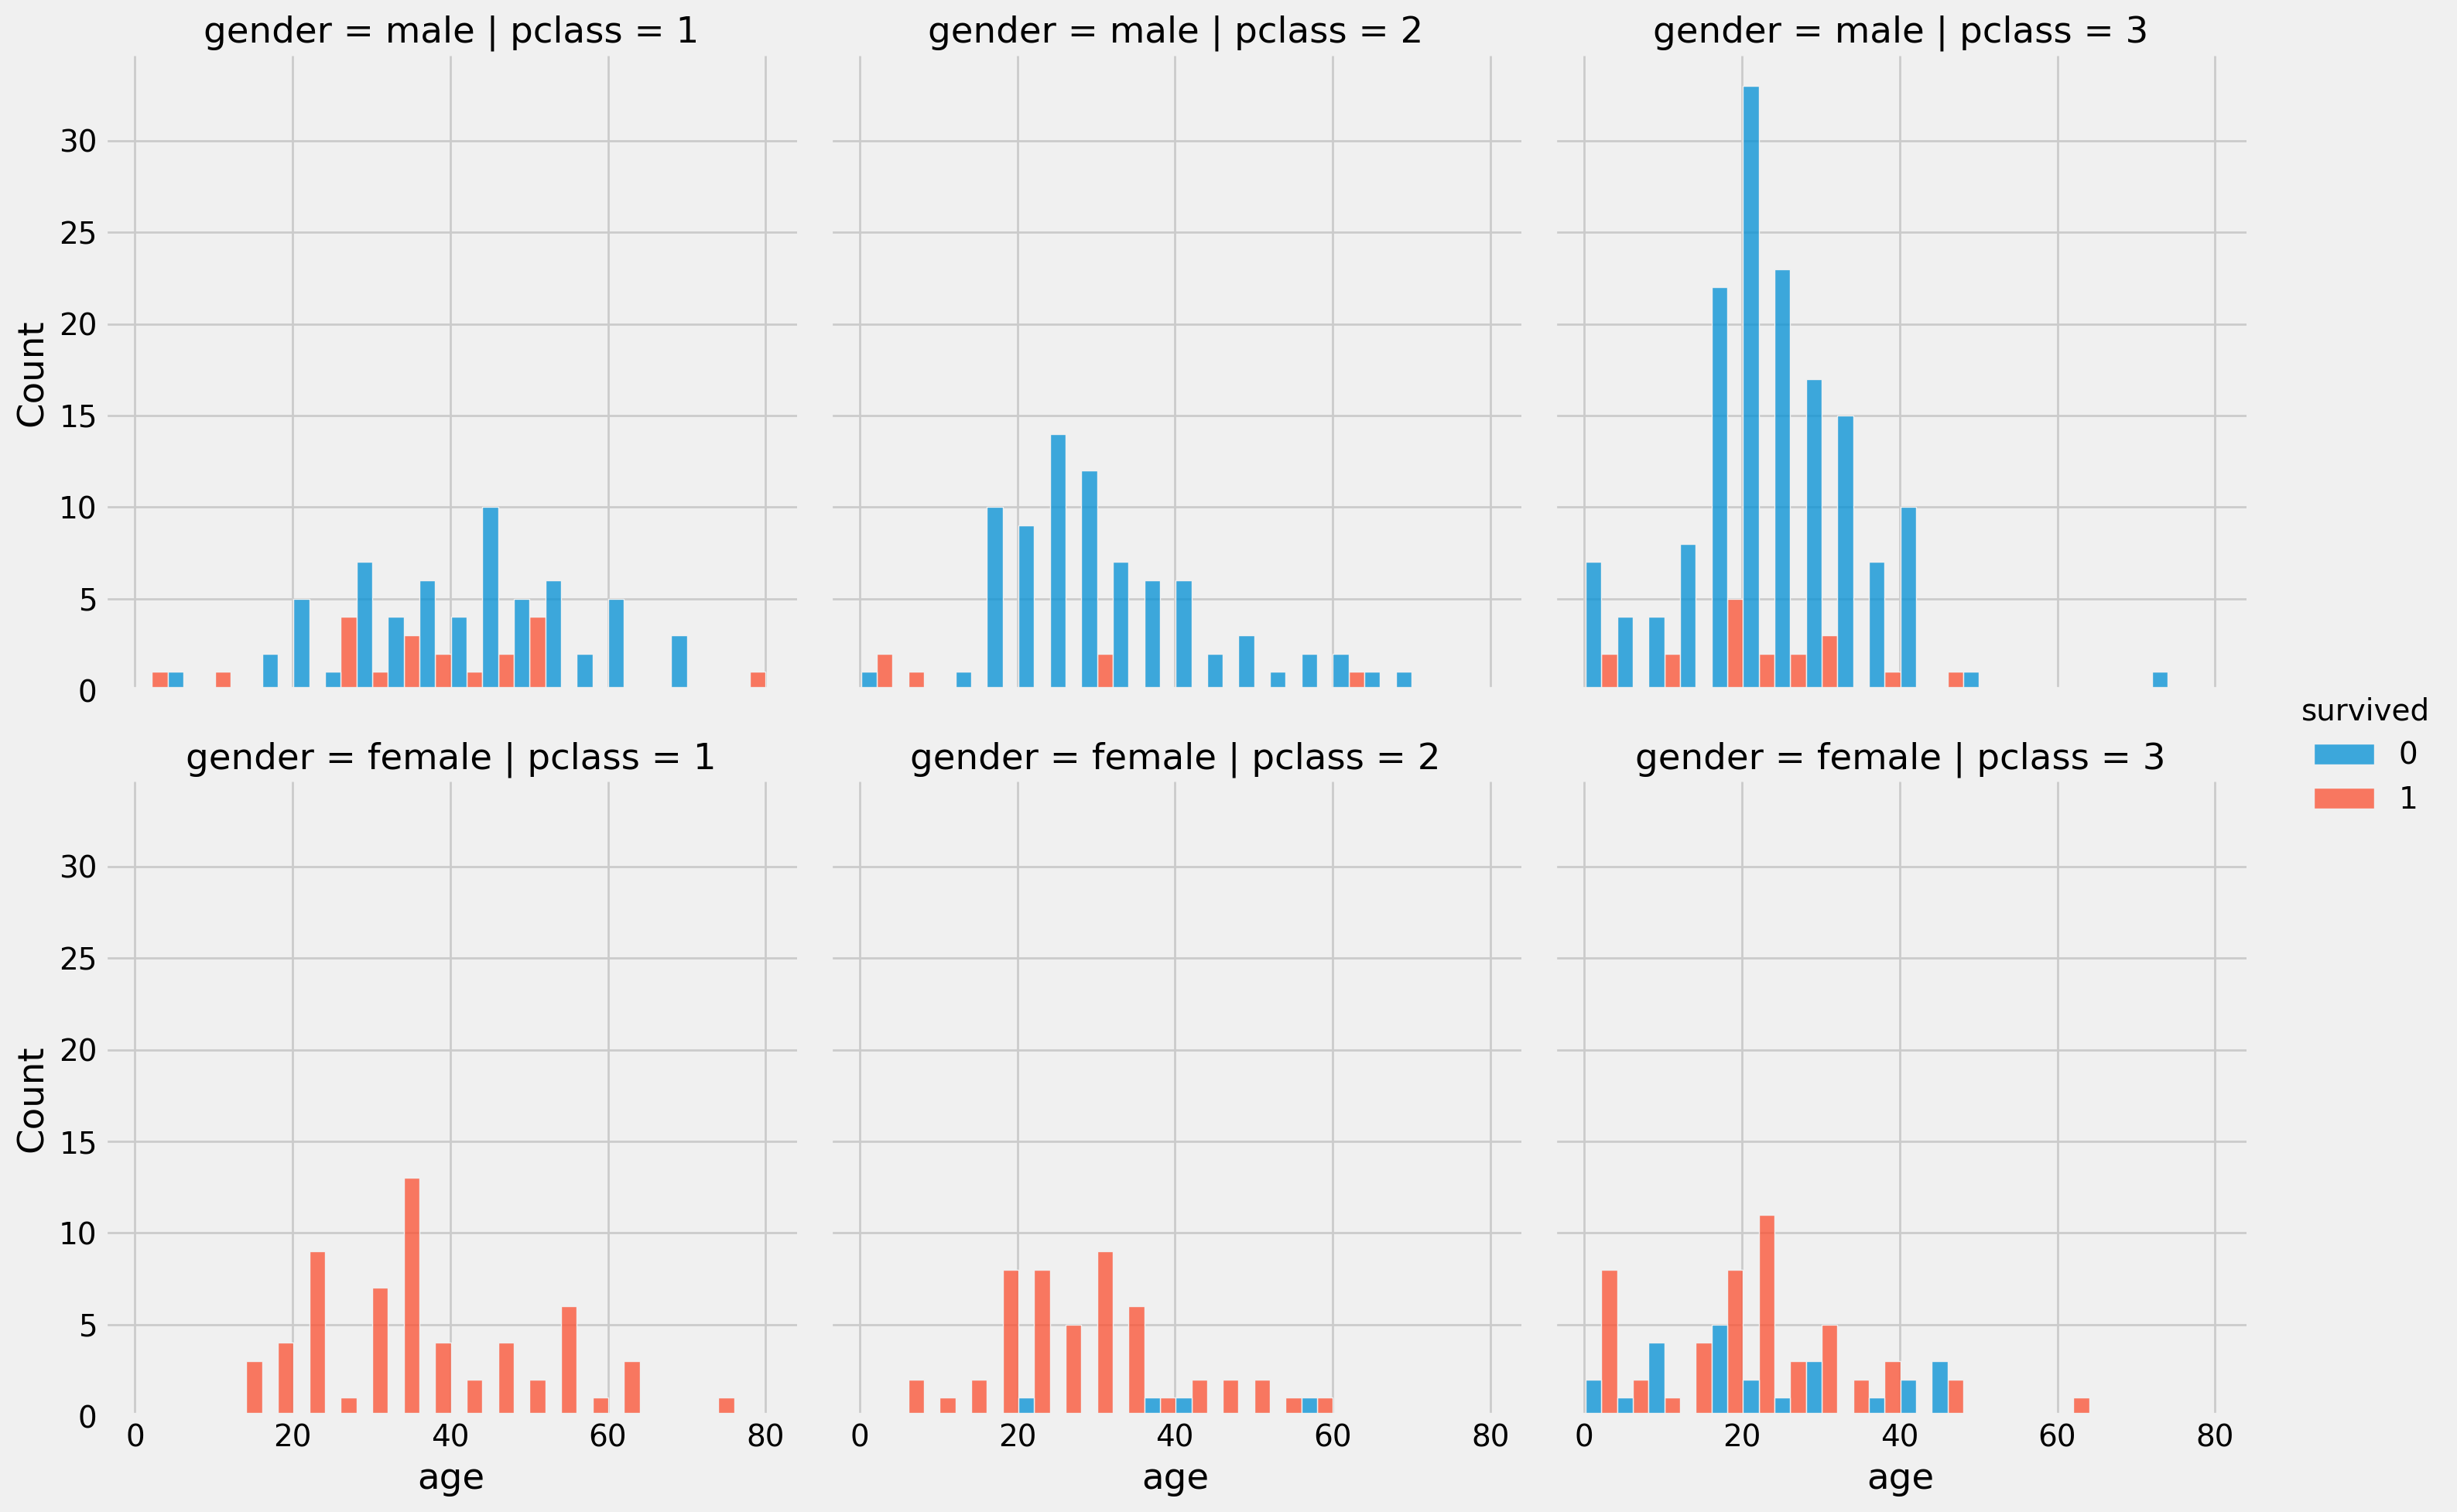

In [25]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

add gender_pclass

In [26]:
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"{train['gender_pclass'].nunique()} / \n {train['gender_pclass'].unique()} \n")
train.shape, test.shape, ori_te.shape

6 / 
 ['male_1' 'female_1' 'male_3' 'male_2' 'female_3' 'female_2'] 



((641, 13), (275, 13), (393, 12))

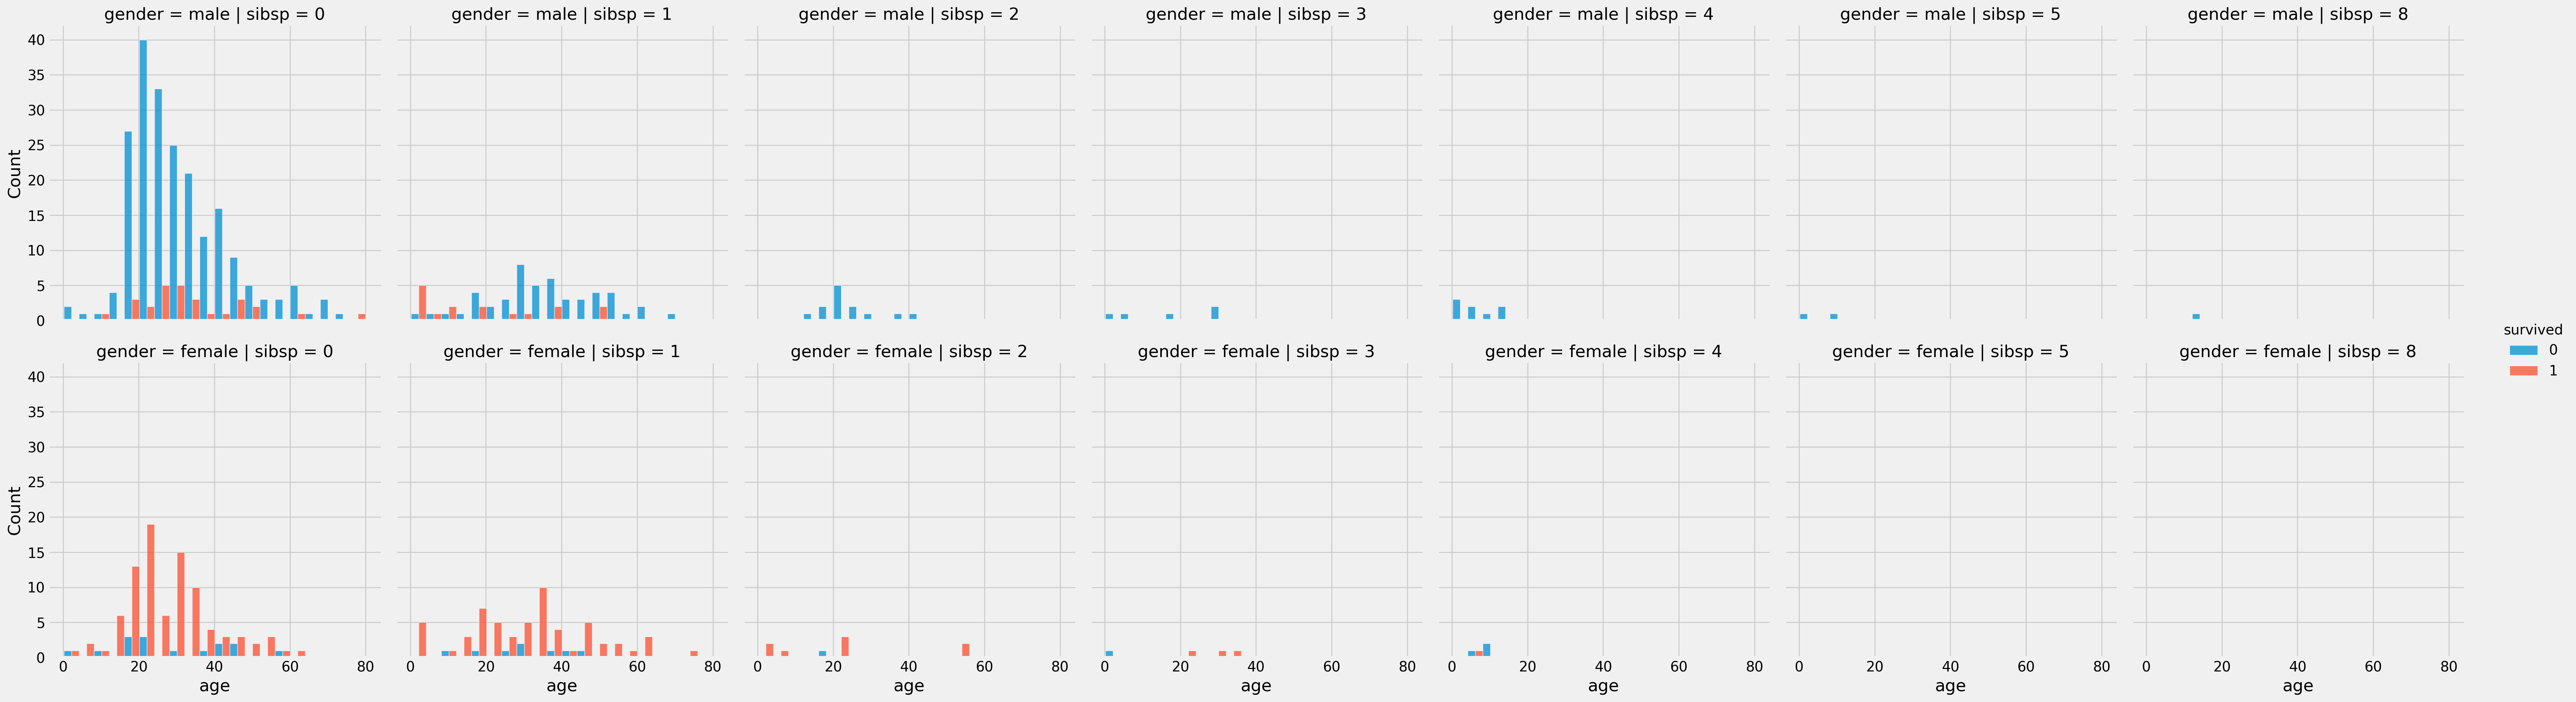

In [27]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

add gender_sibsp

In [28]:
def add_gender_sibsp(gender, sibsp):
  result = None
  try:
    if sibsp < 2:
      result = gender+'_'+str(sibsp)
    else:
      result = gender+'_2'
  except:
    pass
  return result

train['gender_sibsp'] = train.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
test['gender_sibsp'] = test.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
ori_te['gender_sibsp'] = ori_te.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)

print(f"{train['gender_sibsp'].nunique()} / \n {train['gender_sibsp'].unique()} \n")
train.shape, test.shape, ori_te.shape

6 / 
 ['male_0' 'female_0' 'male_2' 'male_1' 'female_1' 'female_2'] 



((641, 14), (275, 14), (393, 13))

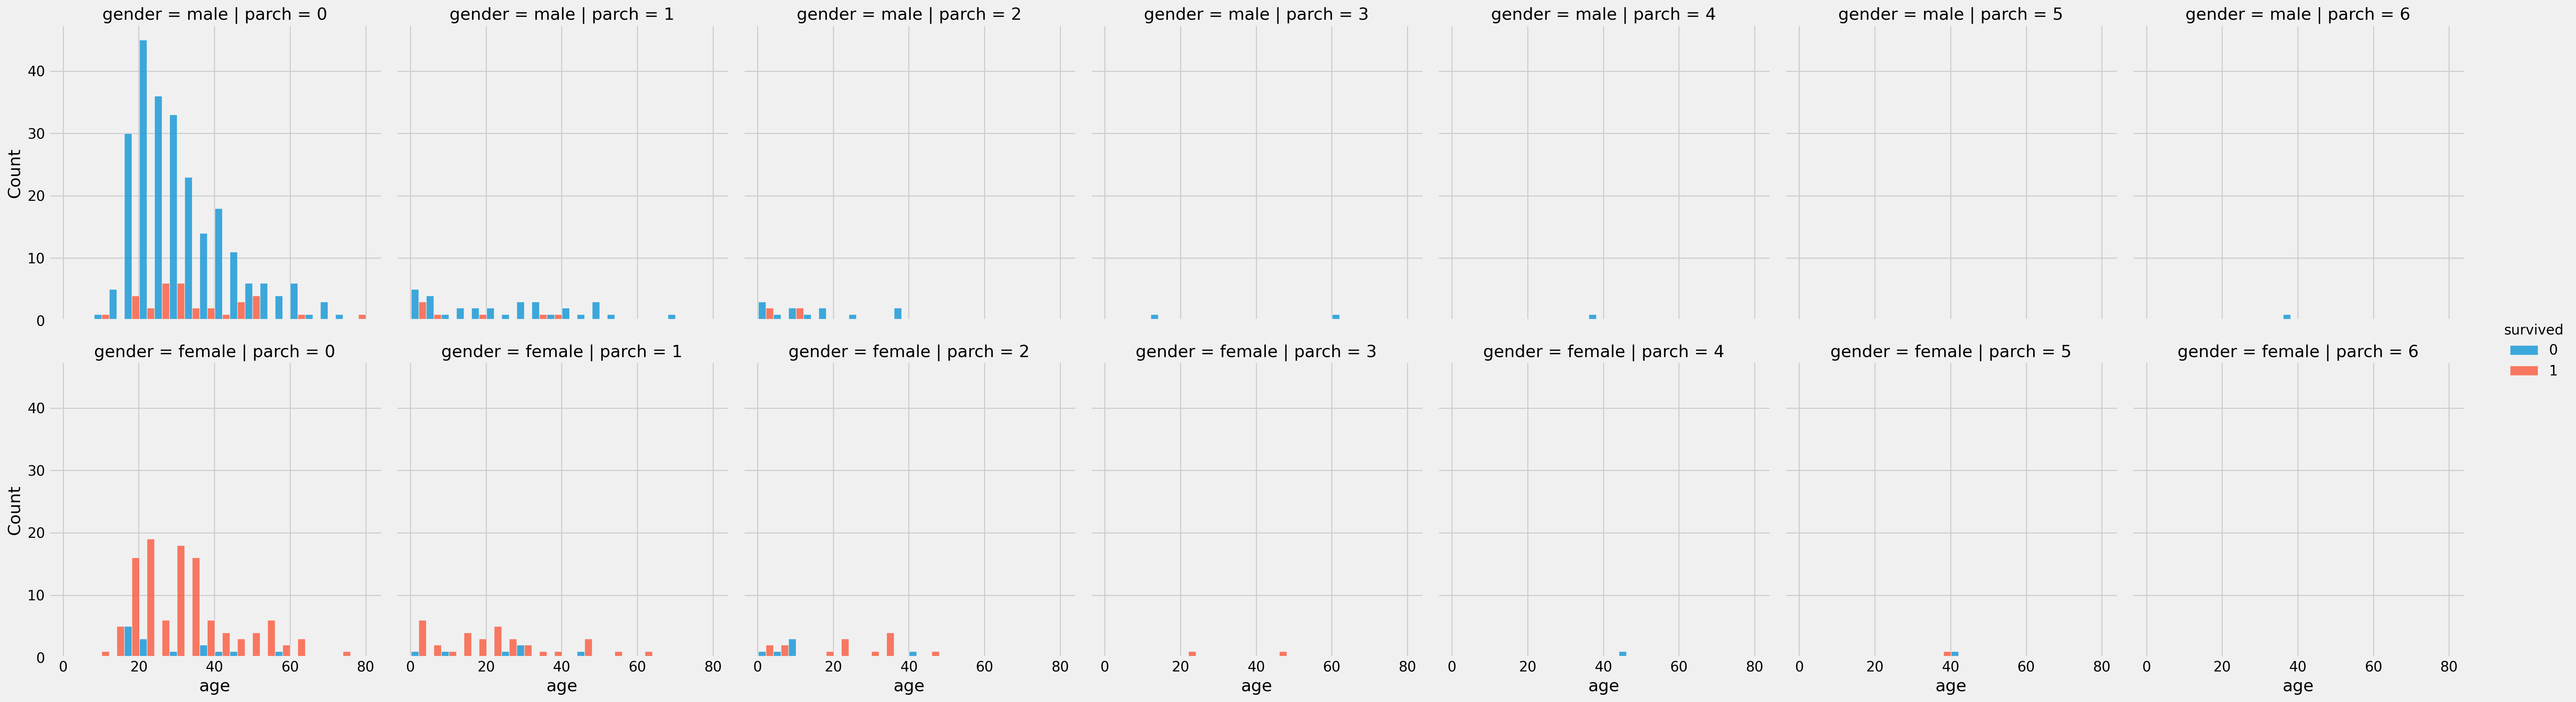

In [29]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

add gender_parch

In [30]:
train['parch'].unique()

array([0, 4, 2, 3, 1, 6, 5])

In [31]:
train['gender_parch'] = train.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
test['gender_parch'] = test.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
ori_te['gender_parch'] = ori_te.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)

print(f"{train['gender_parch'].nunique()} / \n {train['gender_parch'].unique()} \n")
train.shape, test.shape, ori_te.shape

4 / 
 ['male_0' 'female_0' 'female_1' 'male_1'] 



((641, 15), (275, 15), (393, 14))

fare

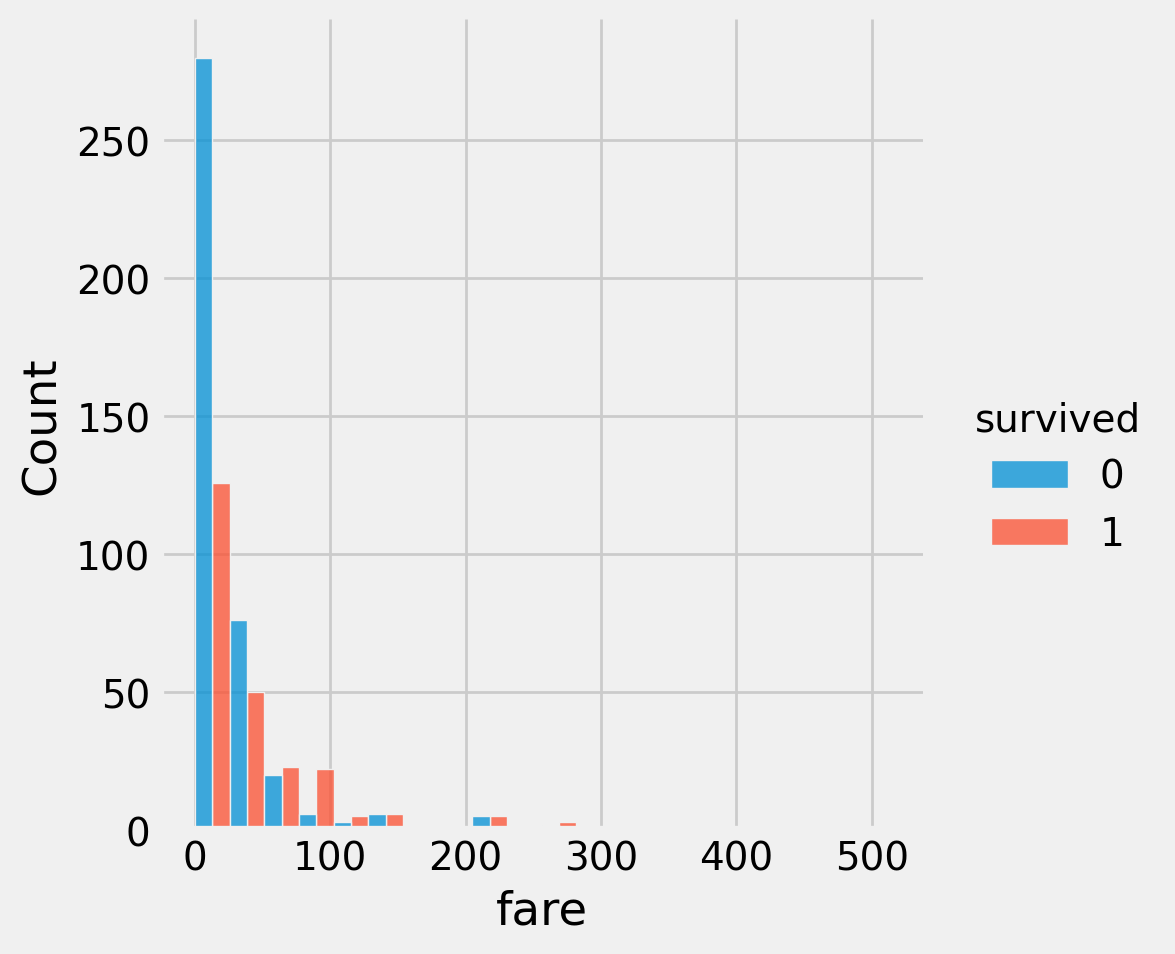

In [32]:
sns.displot(train, x='fare', hue="survived", multiple="dodge", bins=20)

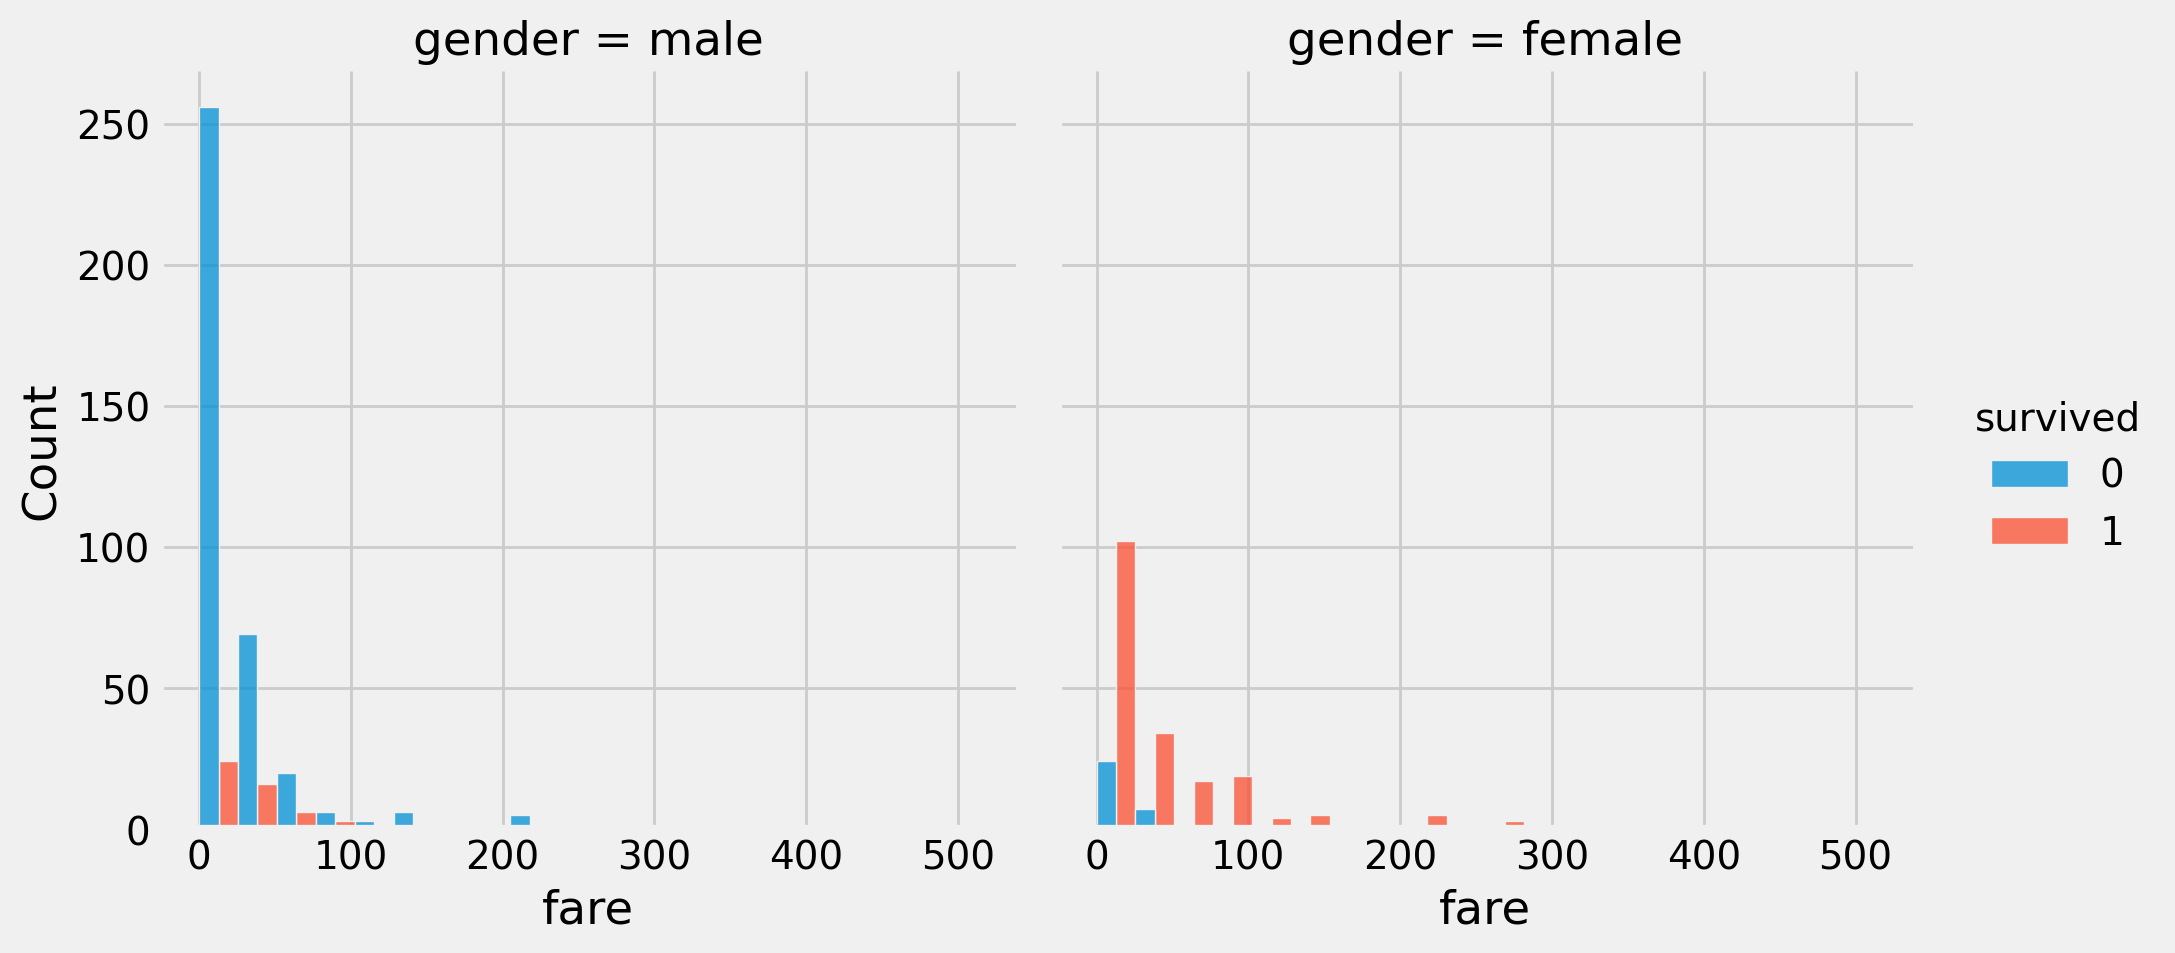

In [33]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="gender")

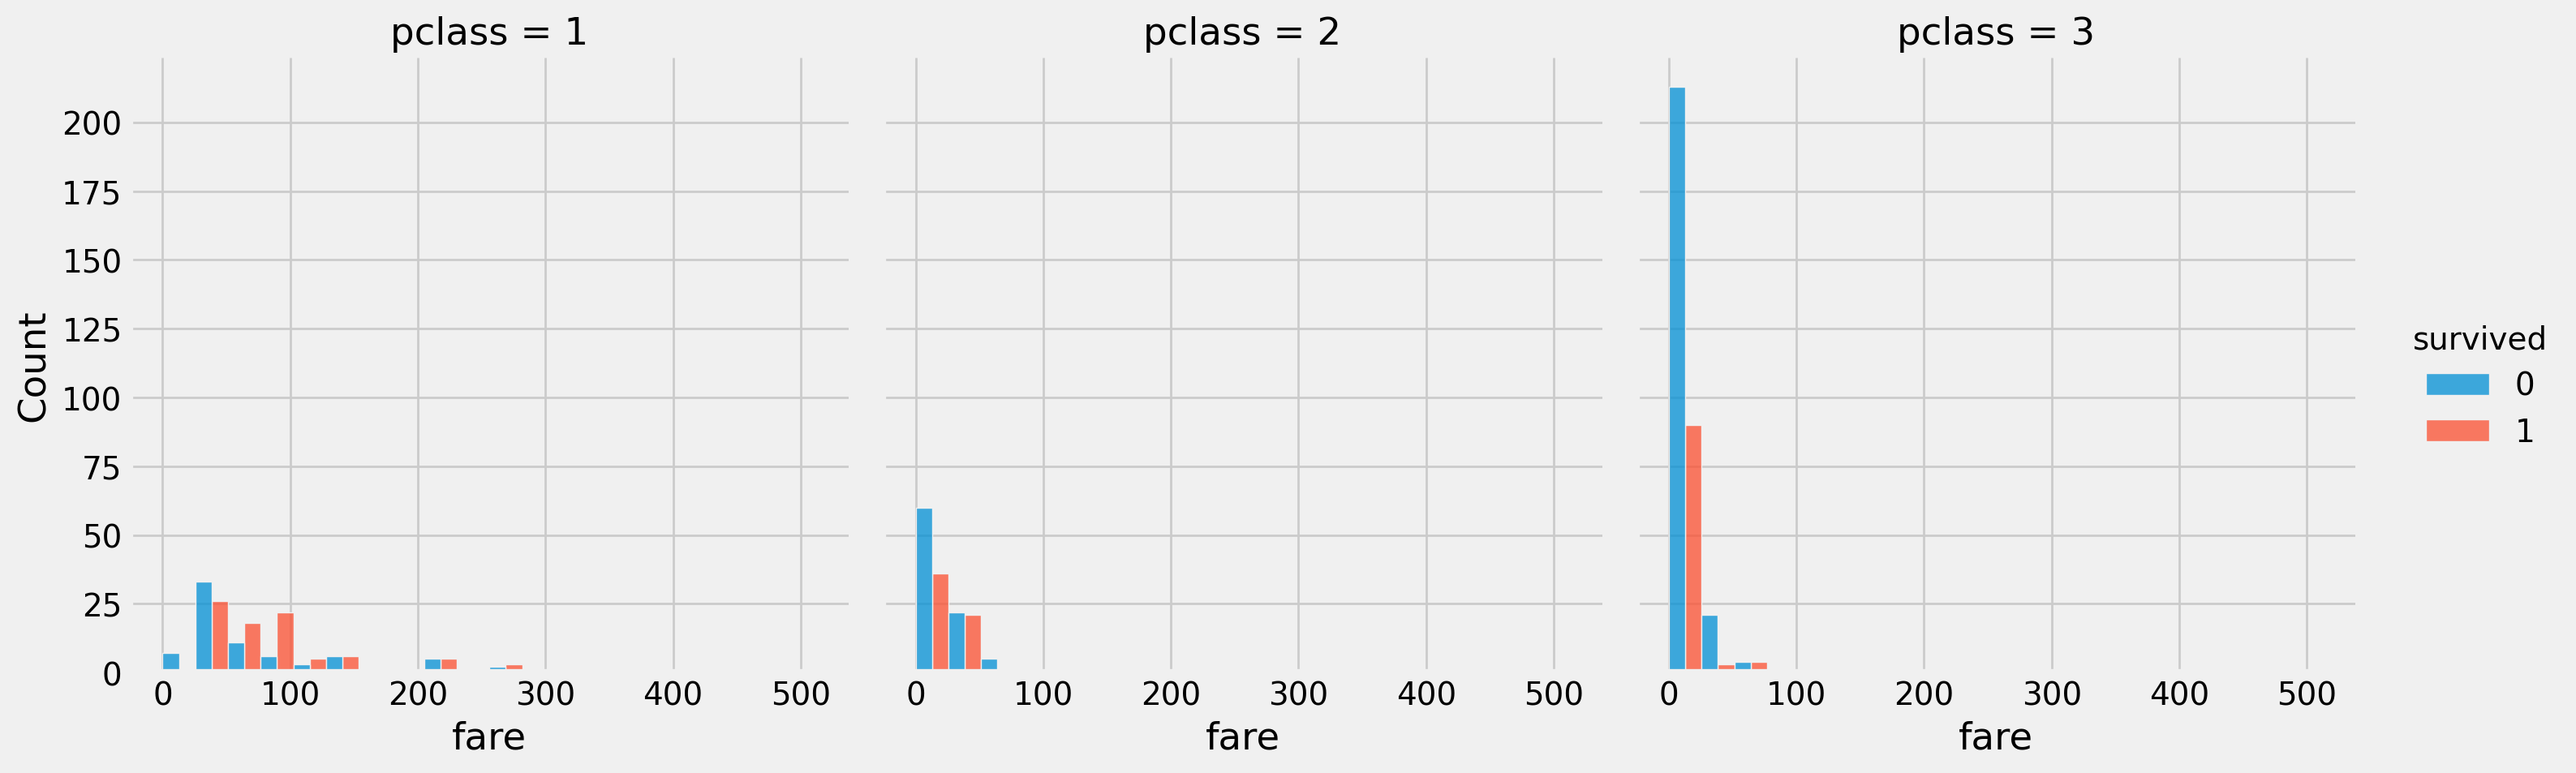

In [34]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass")

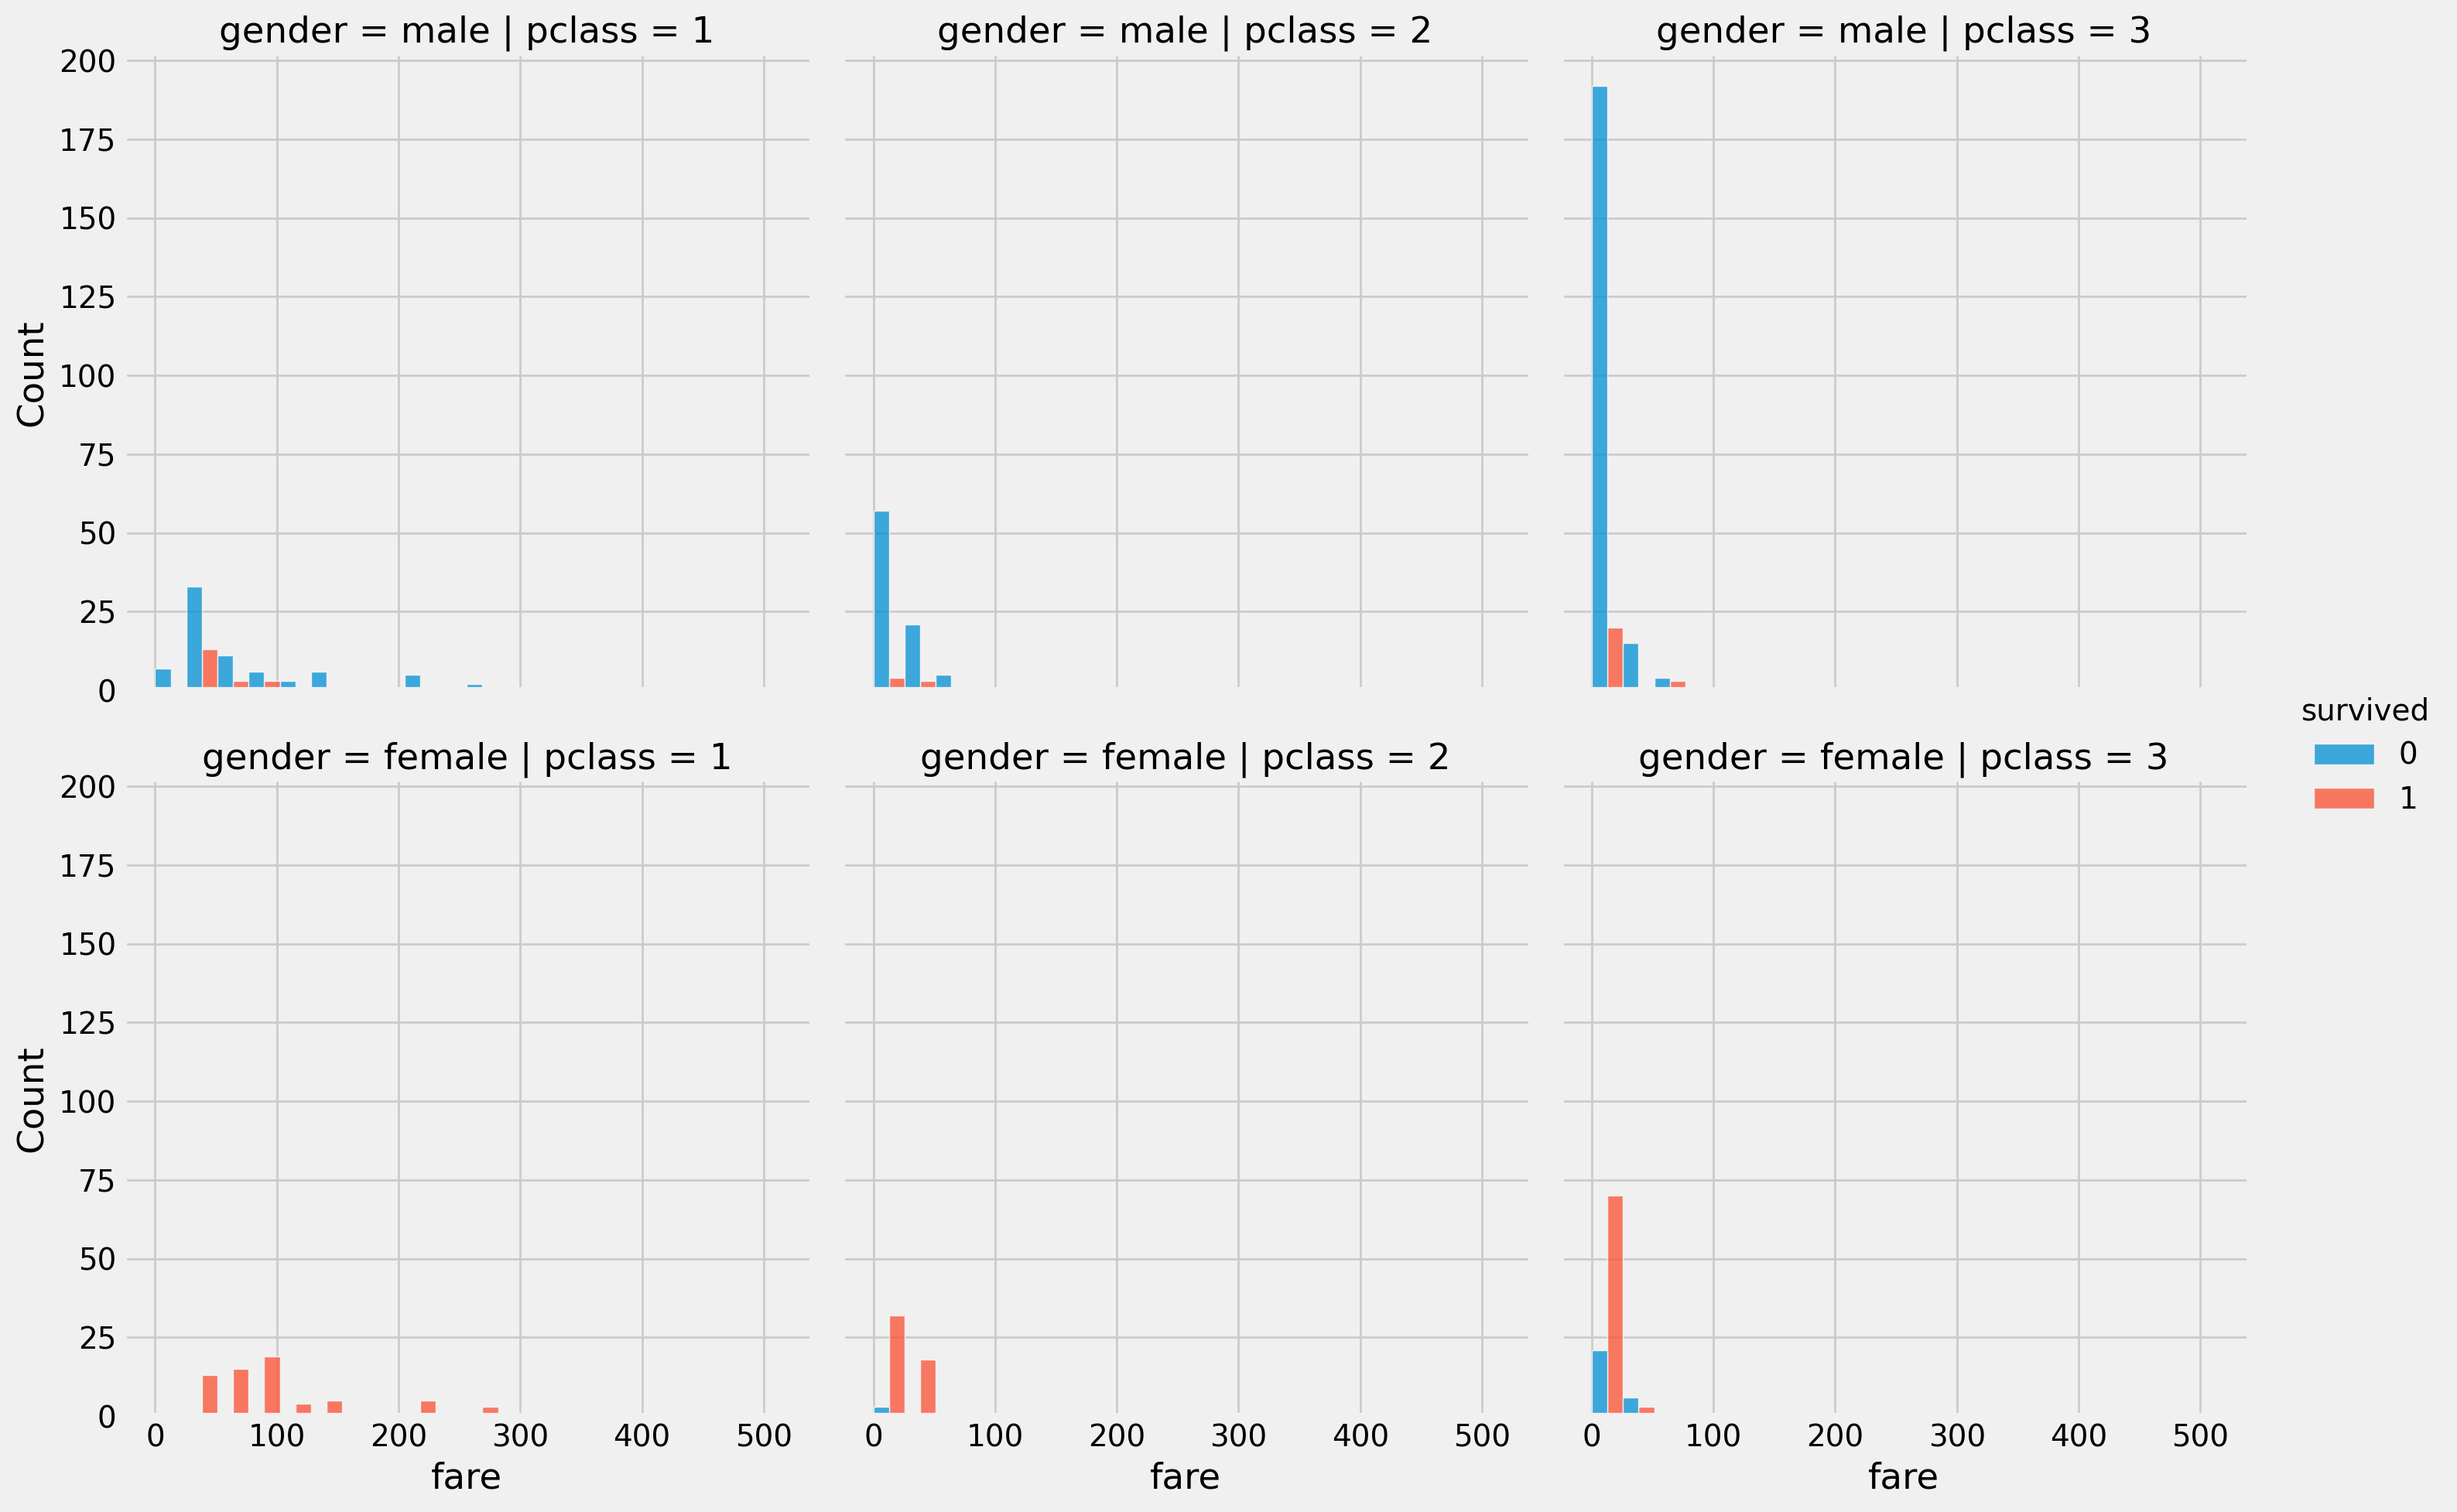

In [35]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [36]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch'],
      dtype='object')

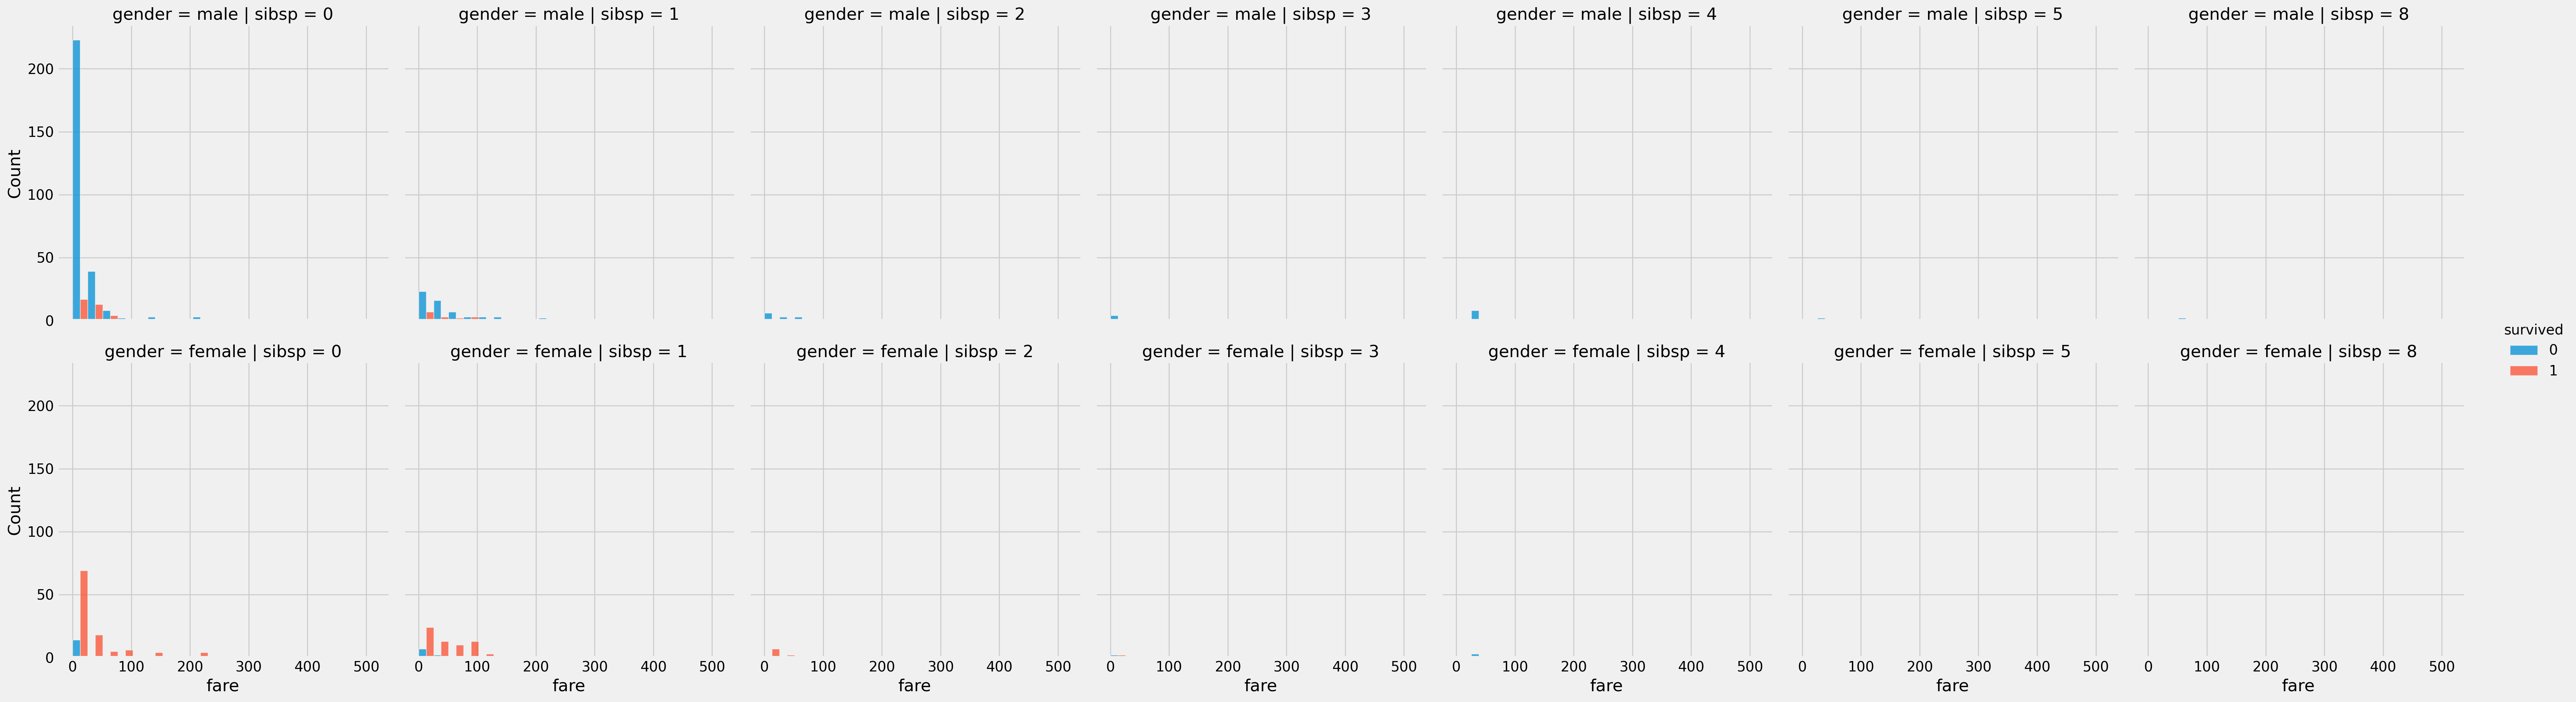

In [37]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

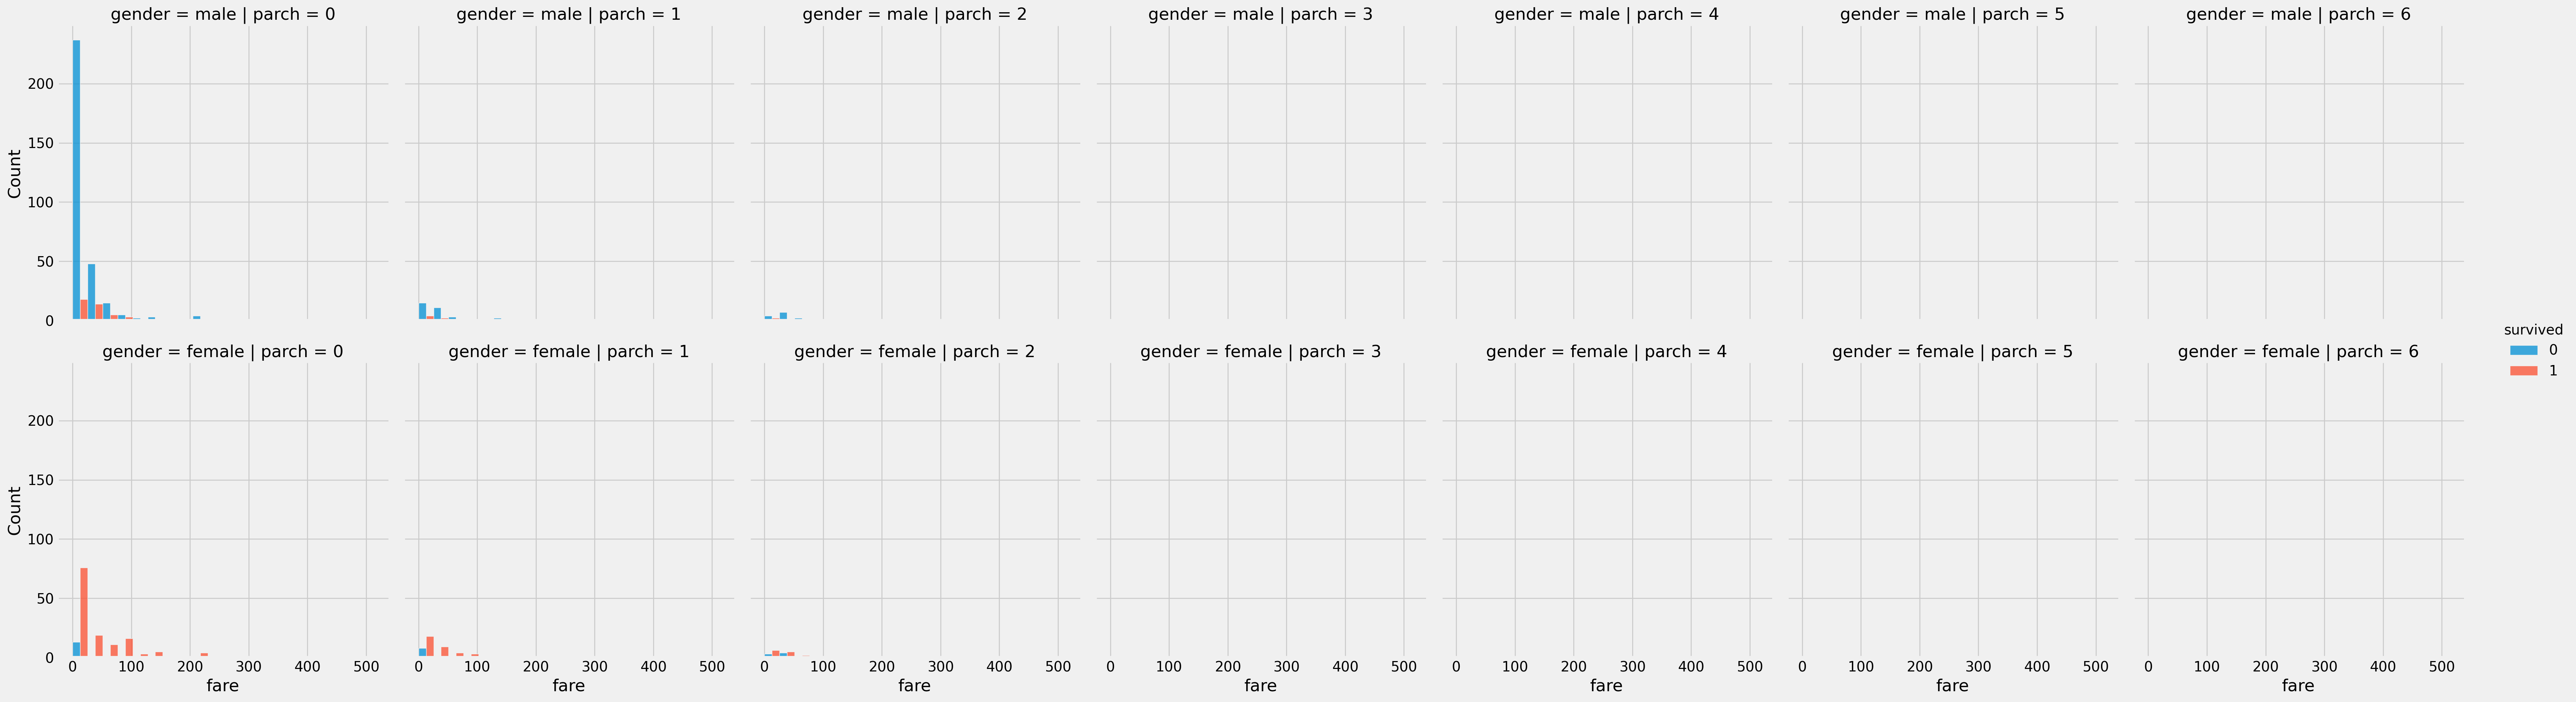

In [38]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

### ordinal features

In [39]:
ordinal_cols = ['pclass', 'sibsp', 'parch'] + ['survived']

train[ordinal_cols].describe()

pclass       sibsp       parch    survived
count  641.000000  641.000000  641.000000  641.000000
mean     2.271451    0.492980    0.324493    0.377535
std      0.837376    0.993902    0.742152    0.485149
min      1.000000    0.000000    0.000000    0.000000
25%      1.000000    0.000000    0.000000    0.000000
50%      3.000000    0.000000    0.000000    0.000000
75%      3.000000    1.000000    0.000000    1.000000
max      3.000000    8.000000    6.000000    1.000000

In [40]:
train[ordinal_cols].corr()

pclass     sibsp     parch  survived
pclass    1.000000  0.077389  0.071752 -0.214195
sibsp     0.077389  1.000000  0.399212  0.015226
parch     0.071752  0.399212  1.000000  0.075825
survived -0.214195  0.015226  0.075825  1.000000

add reversed_pclass

In [41]:
train['reversed_pclass'] = train['pclass'].map(lambda x: 4 - int(x))
test['reversed_pclass'] = test['pclass'].map(lambda x: 4 - int(x))
ori_te['reversed_pclass'] = ori_te['pclass'].map(lambda x: 4 - int(x))

train[ordinal_cols+['reversed_pclass']].corr()

pclass     sibsp     parch  survived  reversed_pclass
pclass           1.000000  0.077389  0.071752 -0.214195        -1.000000
sibsp            0.077389  1.000000  0.399212  0.015226        -0.077389
parch            0.071752  0.399212  1.000000  0.075825        -0.071752
survived        -0.214195  0.015226  0.075825  1.000000         0.214195
reversed_pclass -1.000000 -0.077389 -0.071752  0.214195         1.000000

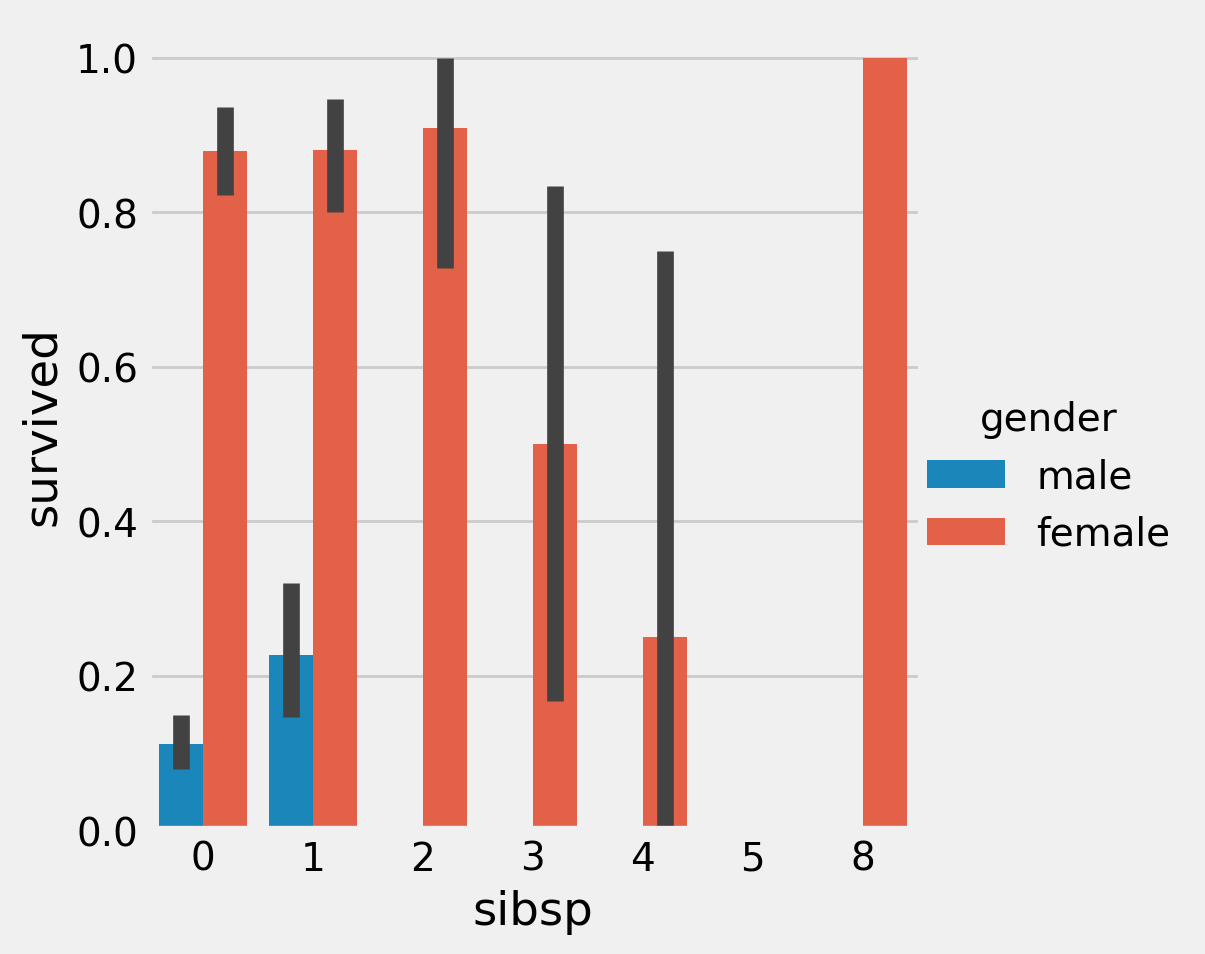

In [42]:
sns.catplot(data=train, x="sibsp", y="survived", hue="gender", kind="bar")

In [43]:
c1 = train['sibsp'] == 8
c2 = train['gender'] == 'female'
c = c1 & c2
train.loc[c]['survived'].mean()

1.0

In [44]:
c1 = train['sibsp'] >= 2
c2 = train['gender'] == 'male'
c = c1 & c2
train.loc[c]['survived'].mean()

0.0

add sibsp_male

In [45]:
for df in [train, test, ori_te]:
  c1 = df['sibsp'] >= 2
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['sibsp_male'] = c

train.shape, test.shape, ori_te.shape

((641, 17), (275, 17), (393, 16))

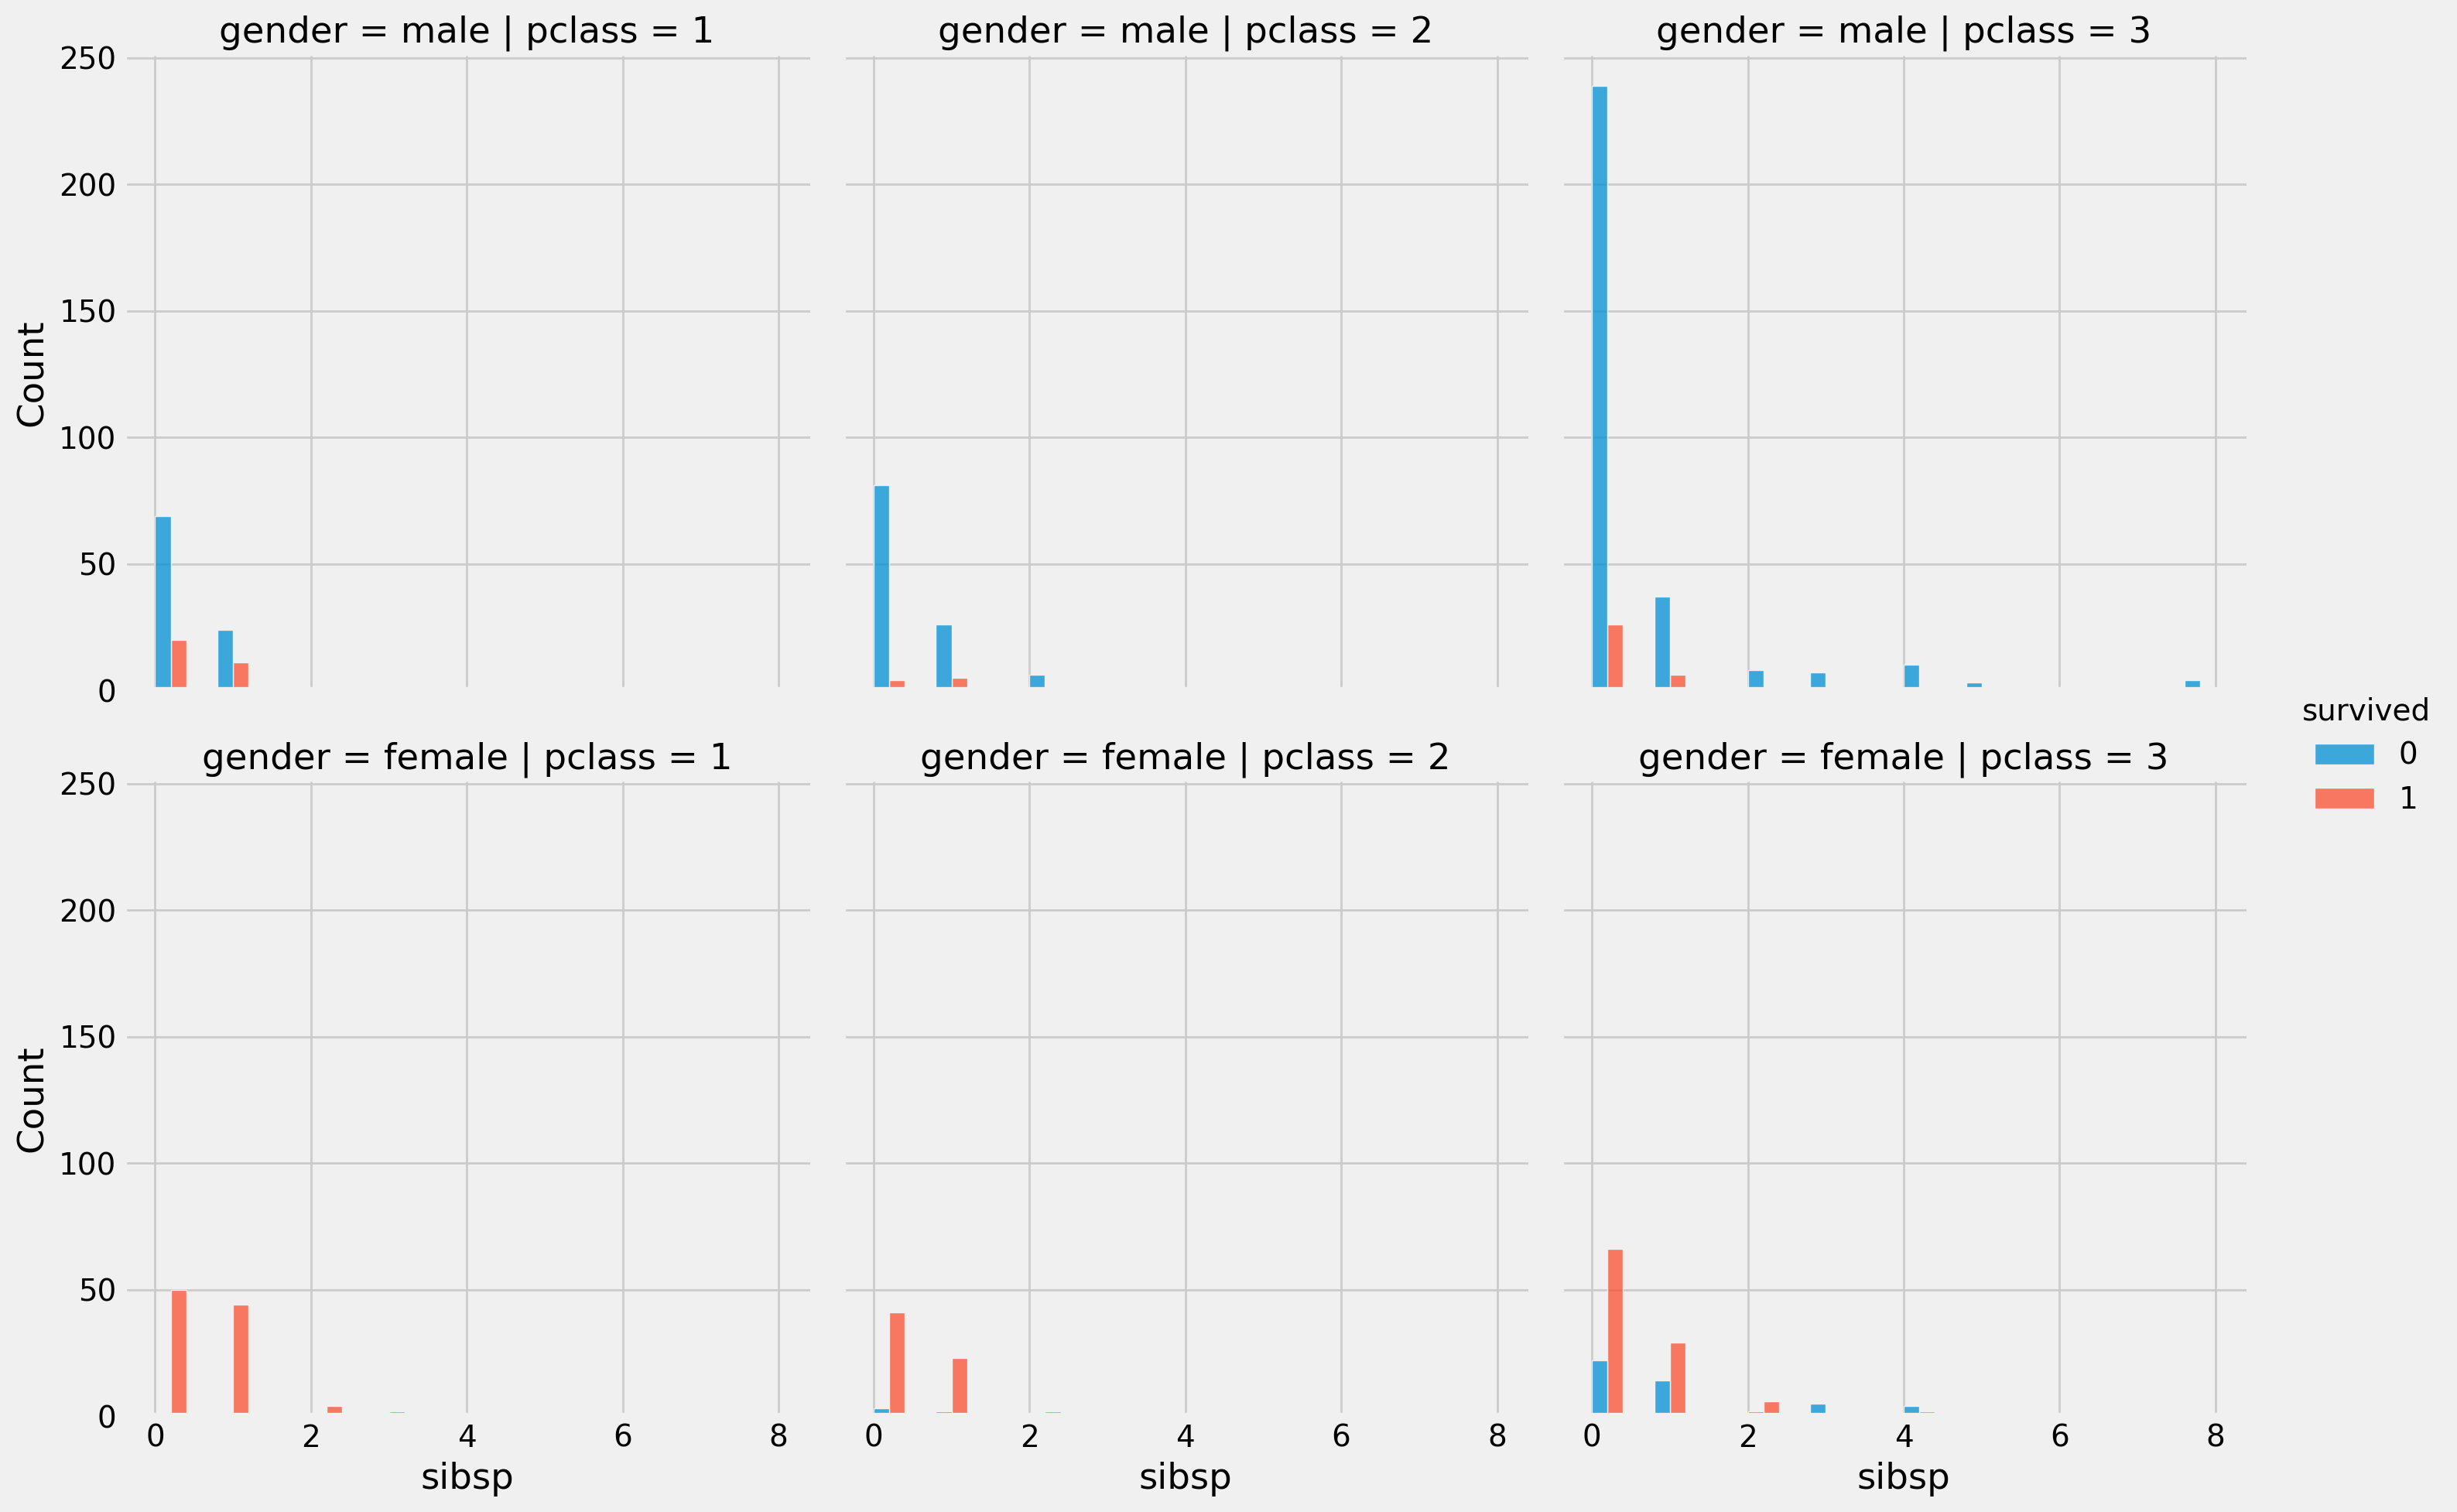

In [46]:
sns.displot(ori_tr, x="sibsp", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [47]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch', 'reversed_pclass',
       'sibsp_male'],
      dtype='object')

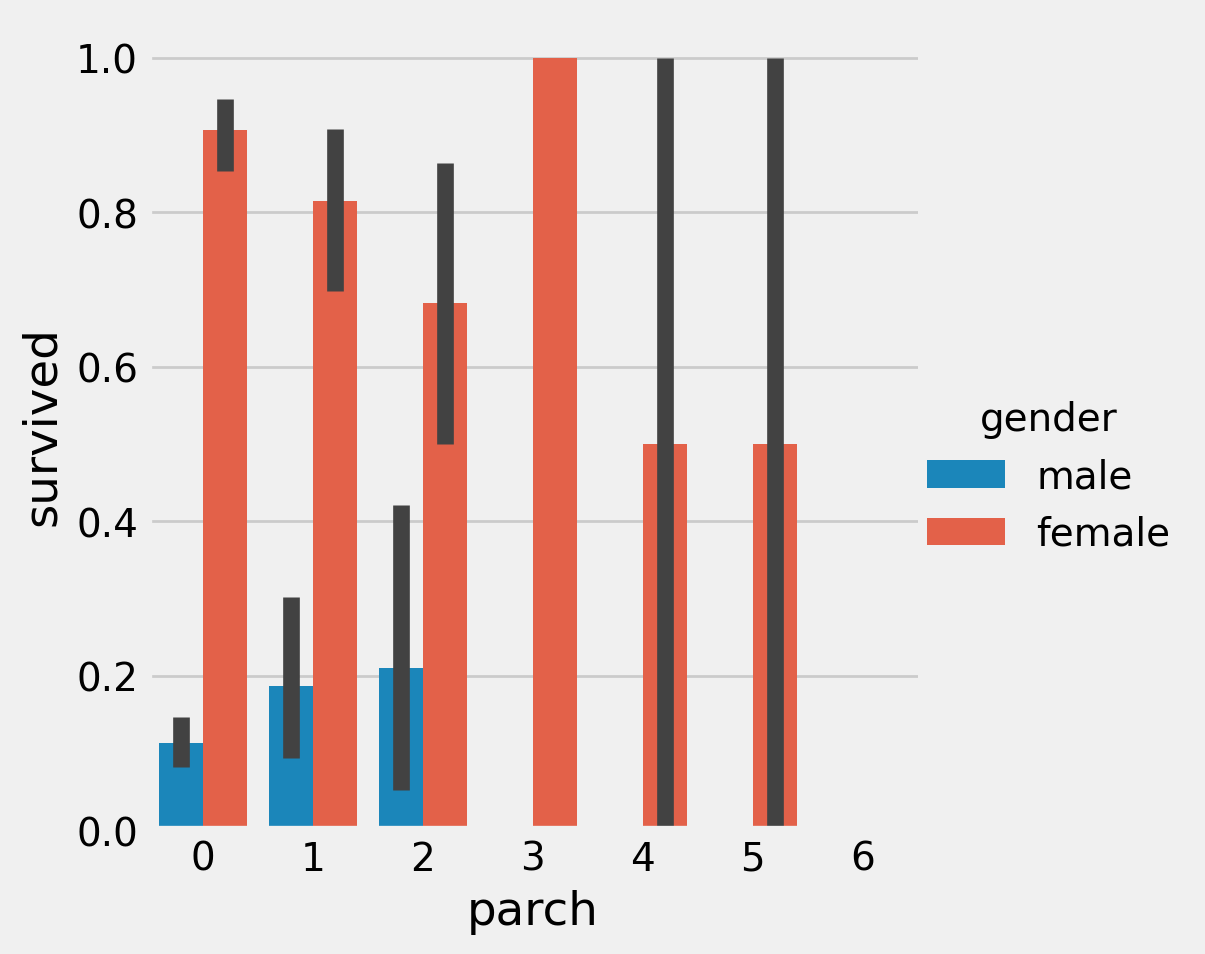

In [48]:
sns.catplot(data=train, x="parch", y="survived", hue="gender", kind="bar")

In [49]:
c1 = train['gender'] == 'male'
c2 = train['parch'] >= 3
c = c1 & c2
train.loc[c]['survived'].mean()

0.0

add parch_male

In [50]:
for df in [train, test, ori_te]:
  c1 = df['parch'] >= 3
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['parch_male'] = c

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

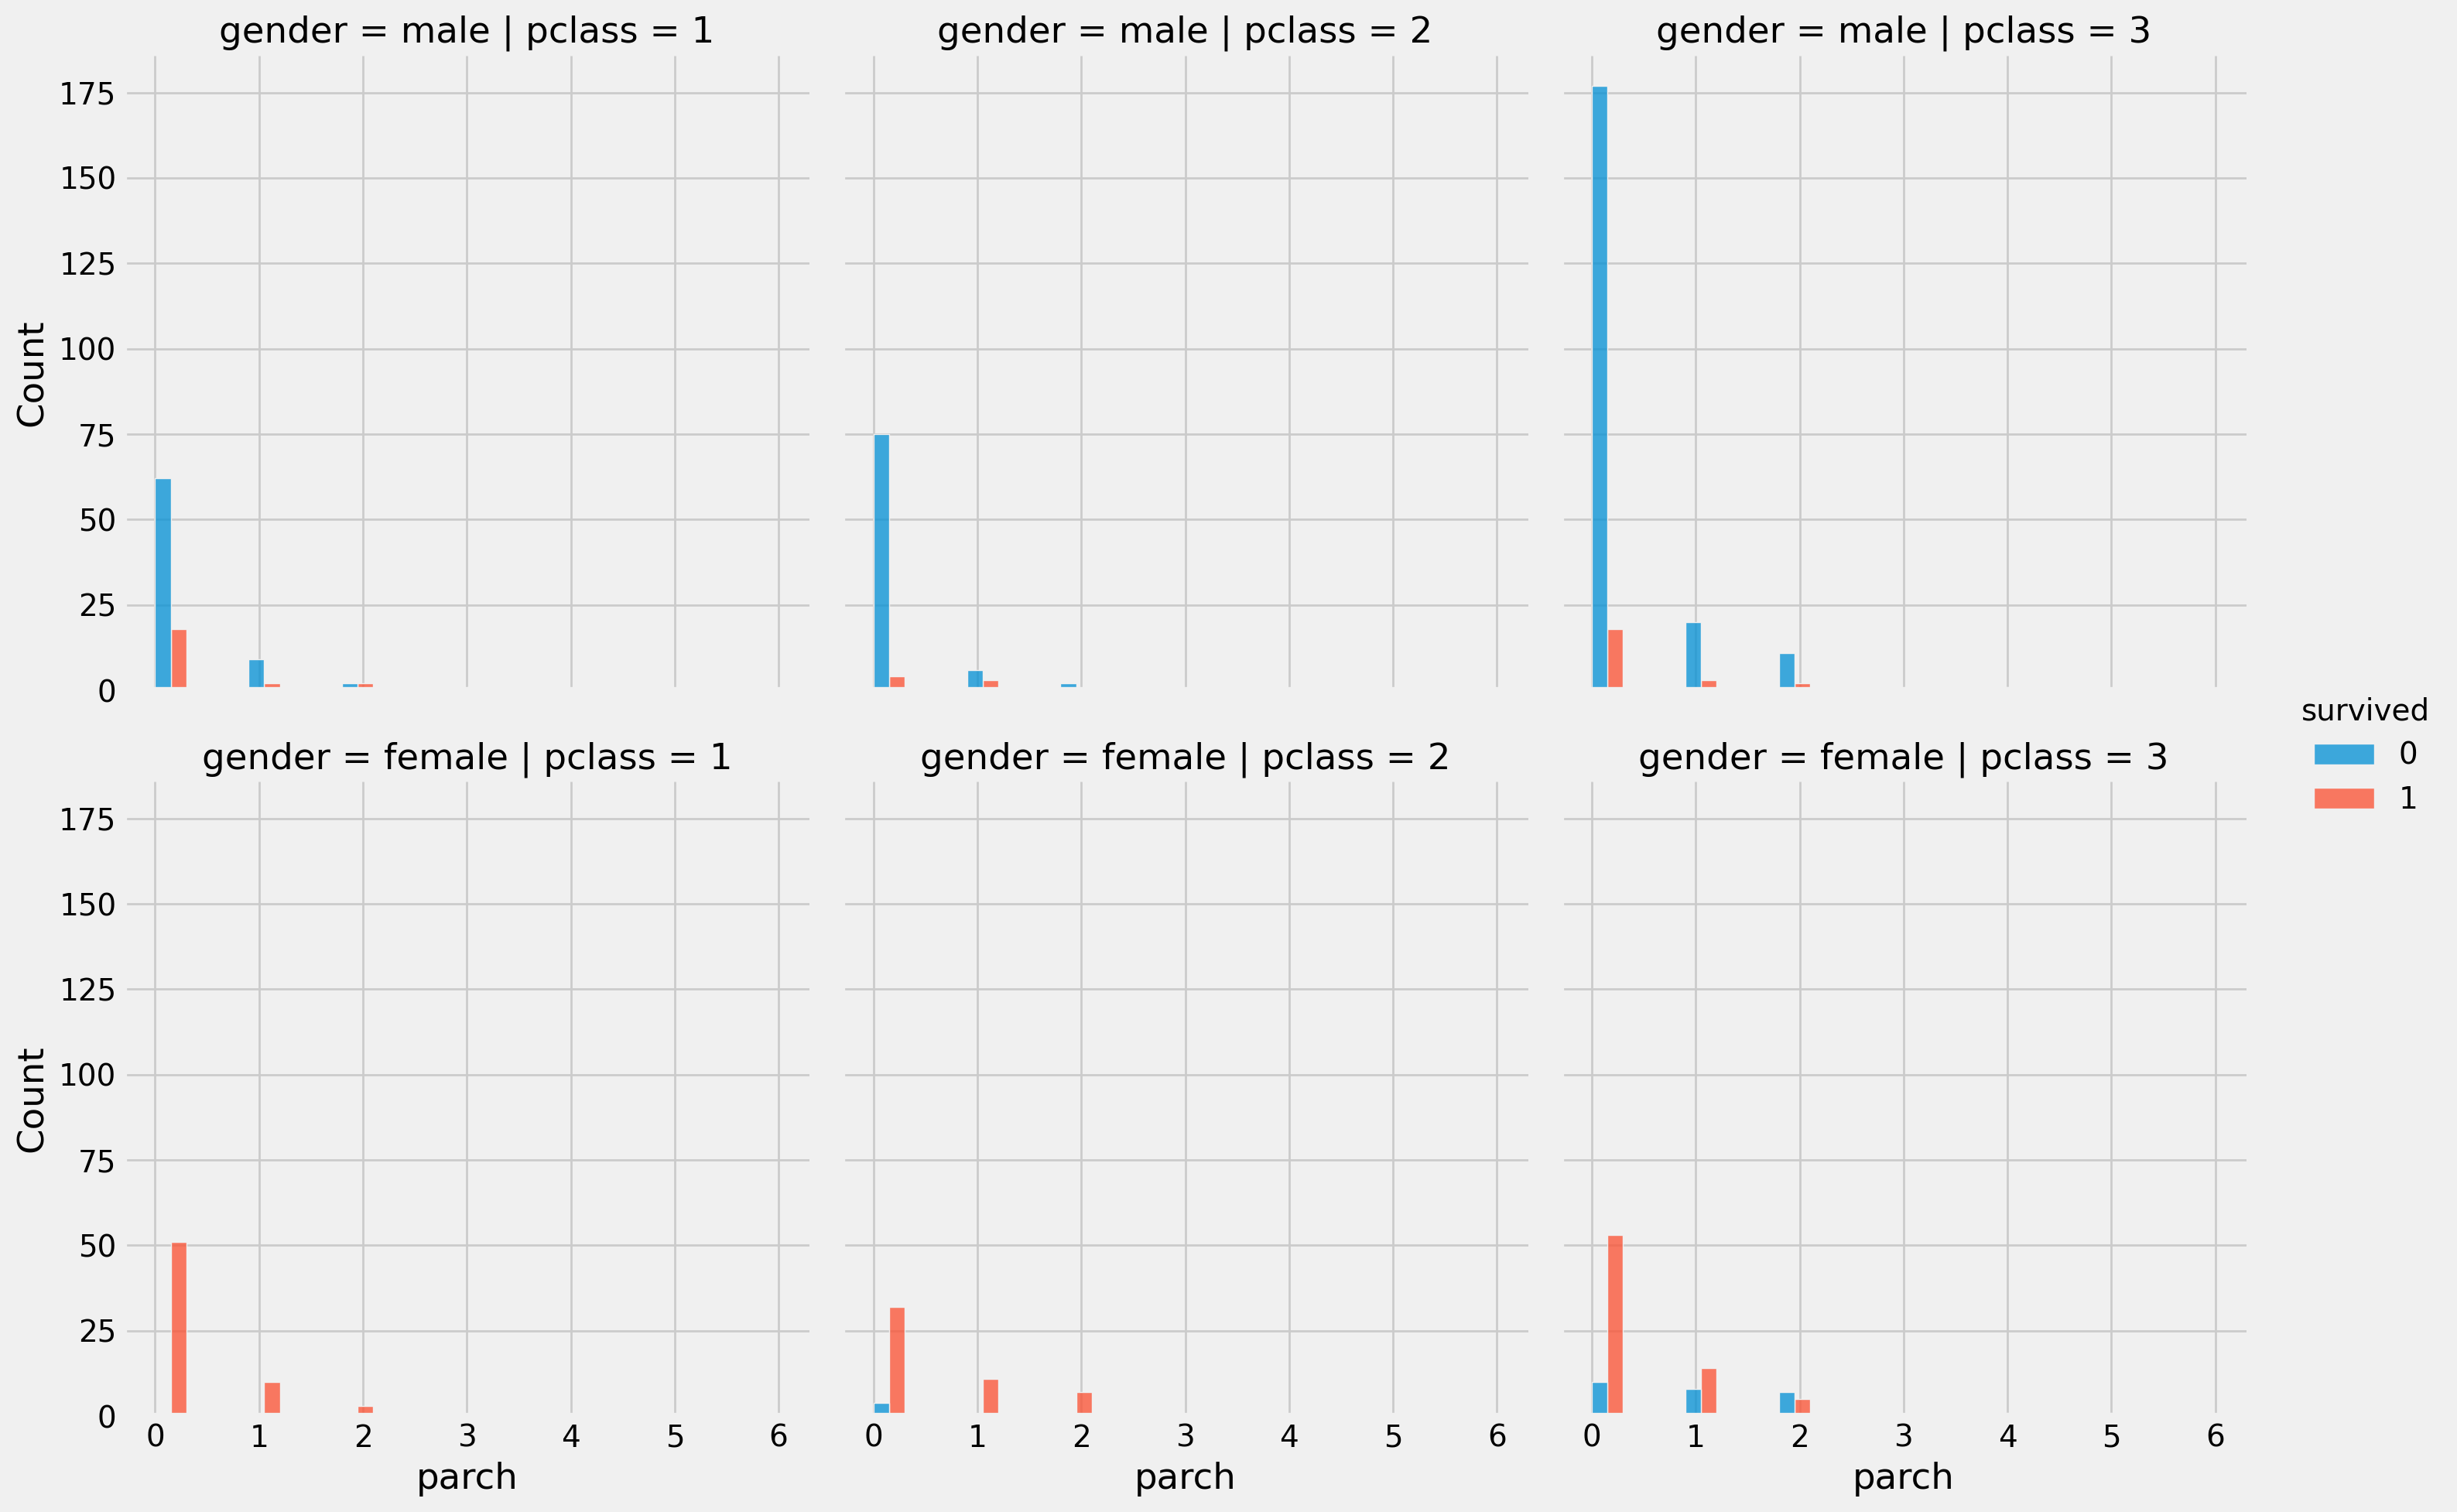

In [51]:
sns.displot(train, x="parch", hue="survived", multiple="dodge", bins=20, col="pclass", row="gender")

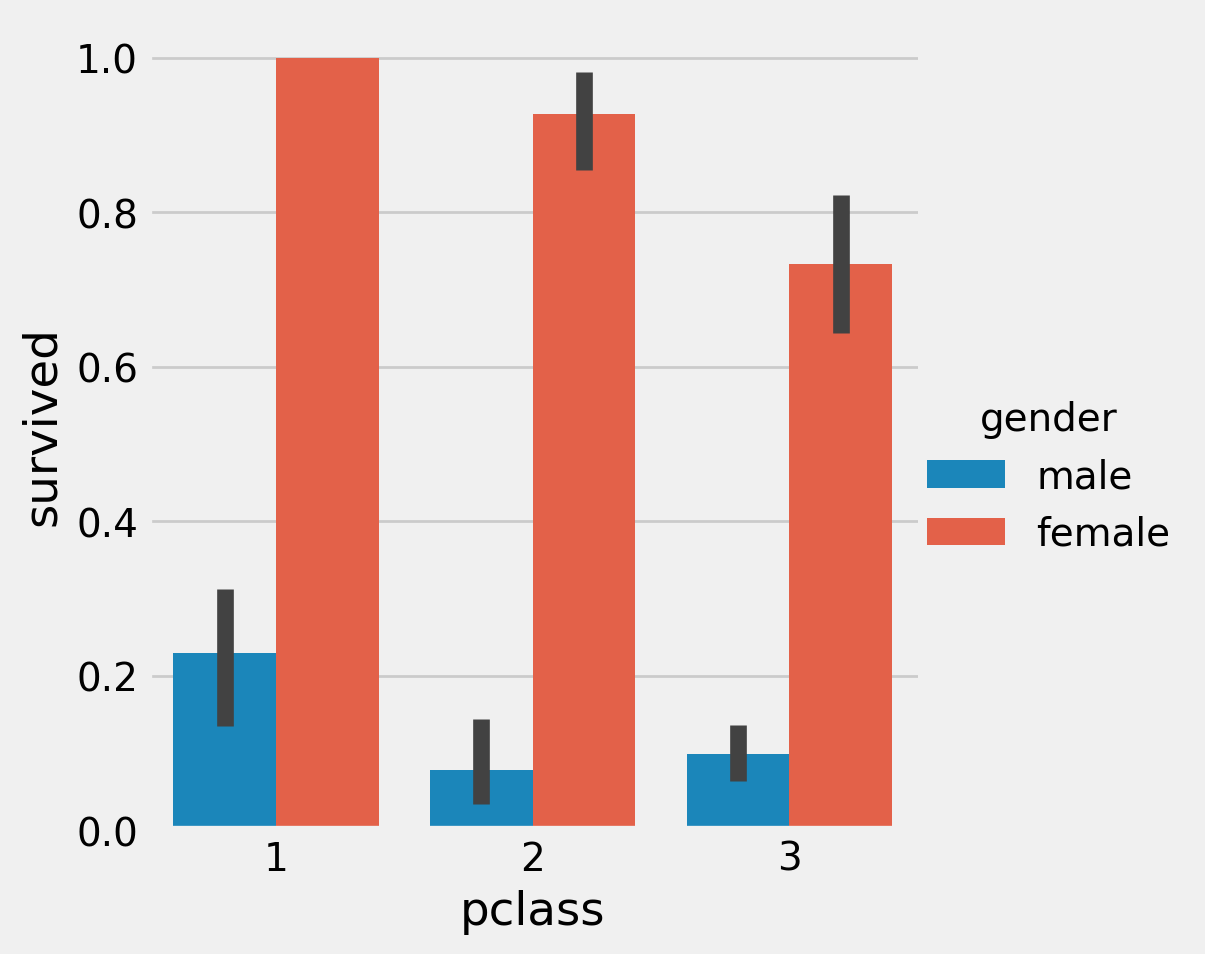

In [52]:
sns.catplot(data=train, x="pclass", y="survived", hue="gender", kind="bar")

### categorical features

In [53]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch', 'reversed_pclass',
       'sibsp_male', 'parch_male'],
      dtype='object')

In [54]:
categorical_cols = ['gender', 'embarked'] + ['survived']
train[categorical_cols].describe(include='all')

gender embarked    survived
count     641      641  641.000000
unique      2        3         NaN
top      male        S         NaN
freq      420      457         NaN
mean      NaN      NaN    0.377535
std       NaN      NaN    0.485149
min       NaN      NaN    0.000000
25%       NaN      NaN    0.000000
50%       NaN      NaN    0.000000
75%       NaN      NaN    1.000000
max       NaN      NaN    1.000000

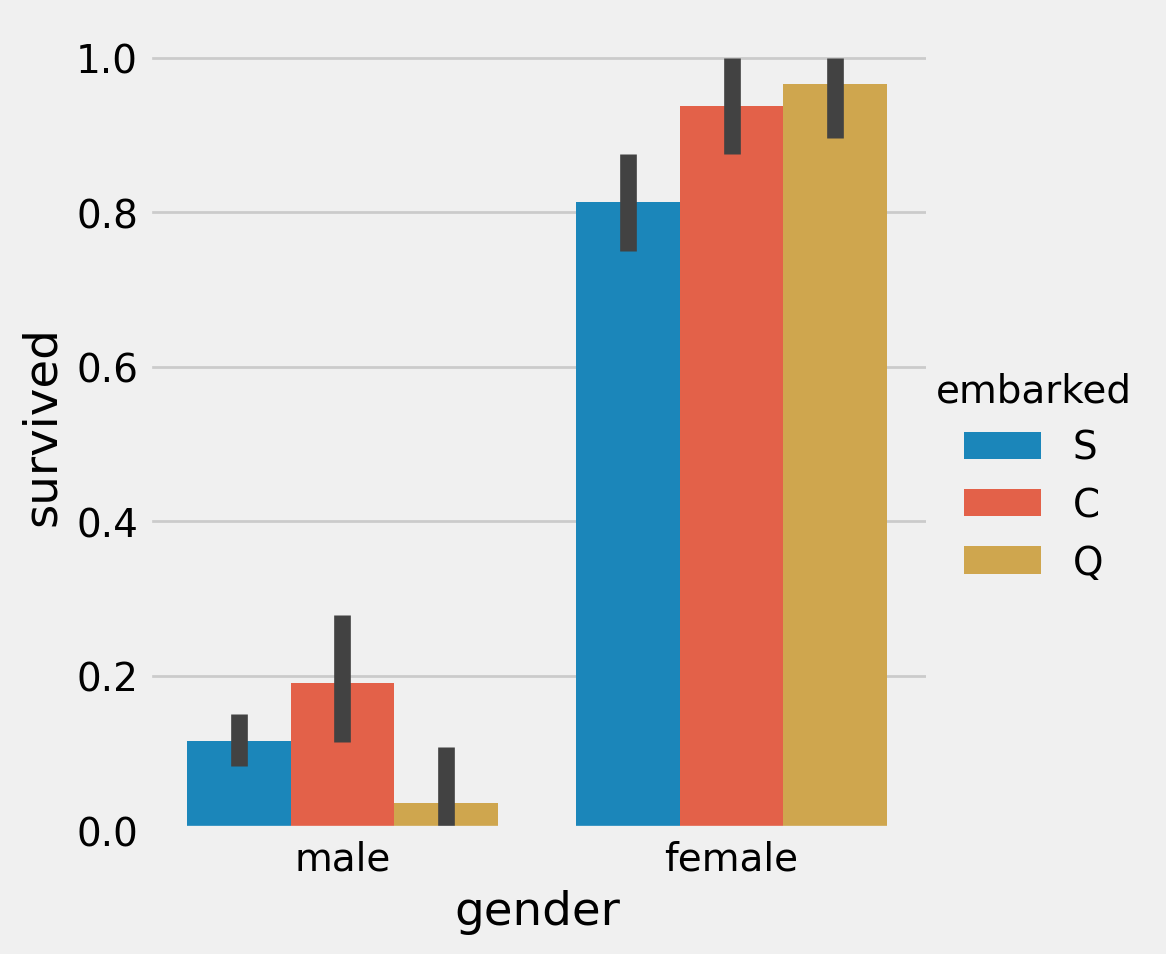

In [55]:
sns.catplot(data=train, x="gender", y="survived", hue="embarked", kind="bar")

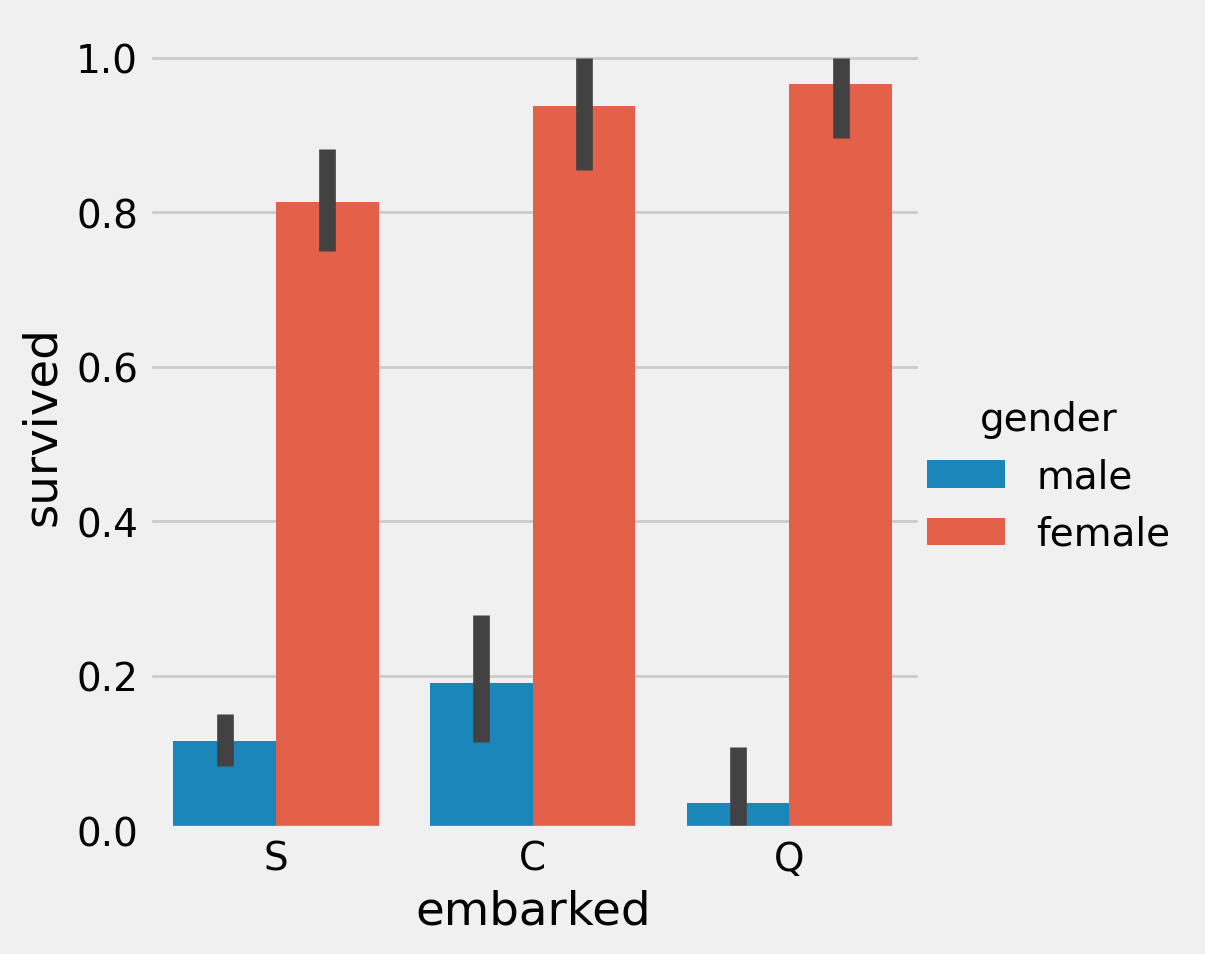

In [56]:
sns.catplot(data=train, x="embarked", y="survived", hue="gender", kind="bar")

### text features

In [57]:
text_cols = ['name', 'ticket']
train[text_cols].head()

name       ticket
539        Klaber, Mr. Herman       113028
339  Young, Miss. Marie Grice     PC 17760
505          Davies, Mr. Evan  SC/A4 23568
492         Kink, Mr. Vincenz       315151
897      Linehan, Mr. Michael       330971

add Initial_name

In [58]:
for df in [train, test, ori_te]:
  df['Initial_name'] = df['name'].str.extract('([A-Za-z]+)\.') #lets extract the Salutations
  df.drop(['name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

add Initial_name_type

In [59]:
train['Initial_name'].unique()

array(['Mr', 'Miss', 'Mrs', 'Master', 'Jonkheer', 'Dr', 'Countess', 'Rev',
       'Col', 'Major', 'Sir', 'Capt'], dtype=object)

In [60]:
train['Initial_name'].value_counts()

Initial_name
Mr          371
Miss        127
Mrs          93
Master       32
Rev           5
Dr            4
Col           3
Major         2
Jonkheer      1
Countess      1
Sir           1
Capt          1
Name: count, dtype: int64

In [61]:
dict_initial_name = {
    'Mr': 'Others',
    'Miss': 'Others',
    'Mrs': 'Others',

    'Master': 'Officer',
    'Rev': 'Officer',
    'Dr': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Capt': 'Officer',

    'Jonkheer': 'Royalty',
    'Countess': 'Royalty',
    'Sir': 'Royalty'
}


def add_initial_name_type(initial_name):
  result = 'Others'
  try:
    result = dict_initial_name[initial_name]
  except:
    pass
  return result

for df in [train, test, ori_te]:
  df['Initial_name_type'] = df['Initial_name'].map(lambda x: add_initial_name_type(x))
  df.drop(['Initial_name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape


((641, 18), (275, 18), (393, 17))

add len_ticket

In [62]:
for df in [train, test, ori_te]:
  df['len_ticket'] = df['ticket'].map(lambda x: len(x.strip().split(' ')))
  df.drop(['ticket'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

### datetime features

## Missing Value

In [63]:
(train.isnull() / train.shape[0]).sum().sort_values(ascending=False)

age                  0.184087
survived             0.000000
gender_pclass        0.000000
Initial_name_type    0.000000
parch_male           0.000000
sibsp_male           0.000000
reversed_pclass      0.000000
gender_parch         0.000000
gender_sibsp         0.000000
gender_infant        0.000000
pclass               0.000000
infant               0.000000
embarked             0.000000
fare                 0.000000
parch                0.000000
sibsp                0.000000
gender               0.000000
len_ticket           0.000000
dtype: float64

In [64]:
(test.isnull() / test.shape[0]).sum().sort_values(ascending=False)

age                  0.225455
embarked             0.003636
survived             0.000000
gender_pclass        0.000000
Initial_name_type    0.000000
parch_male           0.000000
sibsp_male           0.000000
reversed_pclass      0.000000
gender_parch         0.000000
gender_sibsp         0.000000
gender_infant        0.000000
pclass               0.000000
infant               0.000000
fare                 0.000000
parch                0.000000
sibsp                0.000000
gender               0.000000
len_ticket           0.000000
dtype: float64

In [65]:
(ori_te.isnull() / ori_te.shape[0]).sum().sort_values(ascending=False)

age                  0.211196
fare                 0.002545
embarked             0.002545
pclass               0.000000
gender_sibsp         0.000000
Initial_name_type    0.000000
parch_male           0.000000
sibsp_male           0.000000
reversed_pclass      0.000000
gender_parch         0.000000
gender_infant        0.000000
gender_pclass        0.000000
gender               0.000000
infant               0.000000
parch                0.000000
sibsp                0.000000
len_ticket           0.000000
dtype: float64

In [66]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def __get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in __get_cols_cleaning(pd_list):  # for col in cols_cleaning:
    for i, df in enumerate(pd_list, start=1):

      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling

        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)

      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')


In [67]:
add_cols_cleaning(train, test, ori_te)

cols_cleaning: ['age', 'embarked', 'fare']
p_train: 0 / p_test: 0 / p_ori_te: 0


## Scaling

In [68]:
from sklearn.preprocessing import StandardScaler

In [69]:
train.columns

Index(['survived', 'pclass', 'gender', 'sibsp', 'parch', 'embarked', 'infant',
       'gender_infant', 'gender_pclass', 'gender_sibsp', 'gender_parch',
       'reversed_pclass', 'sibsp_male', 'parch_male', 'Initial_name_type',
       'len_ticket', 'age_cleaning', 'fare_cleaning'],
      dtype='object')

In [70]:
scaling_cols = ['age_cleaning', 'fare_cleaning']
scaler = StandardScaler()
scaled_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled,
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = scaled_dfs[0]
test = scaled_dfs[1]
ori_te = scaled_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0 / 0 / 0


((641, 18), (275, 18), (393, 17))

## Encoding

In [71]:
from sklearn.preprocessing import OneHotEncoder

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender_parch       641 non-null    object 
 1   survived           641 non-null    int64  
 2   gender_infant      641 non-null    object 
 3   gender_pclass      641 non-null    object 
 4   sibsp_male         641 non-null    bool   
 5   reversed_pclass    641 non-null    int64  
 6   gender             641 non-null    object 
 7   embarked           641 non-null    object 
 8   parch_male         641 non-null    bool   
 9   len_ticket         641 non-null    int64  
 10  infant             641 non-null    int64  
 11  sibsp              641 non-null    int64  
 12  parch              641 non-null    int64  
 13  pclass             641 non-null    int64  
 14  Initial_name_type  641 non-null    object 
 15  gender_sibsp       641 non-null    object 
 16  age_cleaning       641 non

In [73]:
for df in [train, test, ori_te]:
  df['sibsp_male'] = df['sibsp_male'].astype("int32")
  df['parch_male'] = df['parch_male'].astype("int32")

In [74]:
train.head()

gender_parch  survived gender_infant gender_pclass  sibsp_male  \
0       male_0         0        male_0        male_1           0   
1     female_0         1      female_0      female_1           0   
2       male_0         0        male_0        male_3           0   
3       male_0         0        male_0        male_3           1   
4       male_0         0        male_0        male_3           0   

   reversed_pclass  gender embarked  parch_male  len_ticket  infant  sibsp  \
0                3    male        S           0           1       0      0   
1                3  female        C           0           2       0      0   
2                1    male        S           0           2       0      0   
3                1    male        S           0           1       0      2   
4                1    male        Q           0           1       0      0   

   parch  pclass Initial_name_type gender_sibsp  age_cleaning  fare_cleaning  
0      0       1            Others       male_0     -1.729116      -0.114641  
1      0       1            Others     female_0      0.411136       2.204701  
2      0       3            Others       male_0     -0.555429      -0.507990  
3      0       3            Others       male_2     -0.279268      -0.494967  
4      0       3            Others       male_0     -0.279268      -0.511622

In [75]:
train.select_dtypes(exclude=np.number)

gender_parch gender_infant gender_pclass  gender embarked  \
0         male_0        male_0        male_1    male        S   
1       female_0      female_0      female_1  female        C   
2         male_0        male_0        male_3    male        S   
3         male_0        male_0        male_3    male        S   
4         male_0        male_0        male_3    male        Q   
..           ...           ...           ...     ...      ...   
636       male_0        male_0        male_3    male        S   
637     female_0      female_0      female_3  female        C   
638     female_1      female_0      female_3  female        S   
639       male_0        male_0        male_1    male        C   
640       male_1        male_0        male_1    male        S   

    Initial_name_type gender_sibsp  
0              Others       male_0  
1              Others     female_0  
2              Others       male_0  
3              Others       male_2  
4              Others       male_0  
..                ...          ...  
636            Others       male_0  
637            Others     female_1  
638            Others     female_0  
639            Others       male_0  
640           Officer       male_1  

[641 rows x 7 columns]

In [76]:
enc_cols = list(train.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder()
enc_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(),
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = enc_dfs[0]
test = enc_dfs[1]
ori_te = enc_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

len_enc_cols: 7
0 / 0 / 0


((641, 39), (275, 39), (393, 38))

## Modeling

In [78]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((641, 38), (641,), (275, 38), (275,))

In [77]:
from sklearn.model_selection import GridSearchCV

In [93]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score

n_iter=50
num_folds=2 # 학습시간을 줄이기 위해 2로 하였다. 일반적으로는 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=args.random_state)

# import warnings
# warnings.filterwarnings('ignore', category=DeprecationWarning)

hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이 (구간이 있고 해당 구간을 학습)
    "criterion" : ["gini","entropy"], # 순수도 척도 숫자가 아니면 list로 표현
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3),
    'min_samples_split' : np.linspace(0.1, 1.0, 10, dtype = float),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, dtype = float),
    'max_leaf_nodes' : [None, 5, 10, 20],
    'min_impurity_split' : [0.0, 0.0001, 0.0005, 0.001]
    # "verbose" : [-1] # warning 제거
}
model = LGBMClassifier(random_state=args.random_state)

gs=GridSearchCV(model, hp, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=0).fit(X_tr,y_tr)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Info] Number of positive: 242, number of negative: 399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 641, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377535 -> initscore=-0.500024
[LightGBM] [Info] Start training from score -0.500024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [94]:
gs.best_params_

{'criterion': 'gini',
 'learning_rate': 0.01,
 'max_depth': 9,
 'n_estimators': 800}

In [95]:
gs.best_score_

0.8969038951326311

In [96]:
gs.score(X_te,y_te)

[LightGBM] [Warning] Unknown parameter: criterion


0.8910537561853351

In [97]:
from sklearn.metrics import roc_auc_score
pred = gs.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

[LightGBM] [Warning] Unknown parameter: criterion


0.8910537561853351

In [98]:
from sklearn.metrics import classification_report,confusion_matrix
def print_scores(y_te,pred):
  print(confusion_matrix(y_te, pred))
  print('-'*50)
  print(classification_report(y_te, pred))

pred = gs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[LightGBM] [Warning] Unknown parameter: criterion
[[144  27]
 [ 21  83]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       171
           1       0.75      0.80      0.78       104

    accuracy                           0.83       275
   macro avg       0.81      0.82      0.82       275
weighted avg       0.83      0.83      0.83       275



<Axes: xlabel='param_criterion', ylabel='param_n_estimators'>

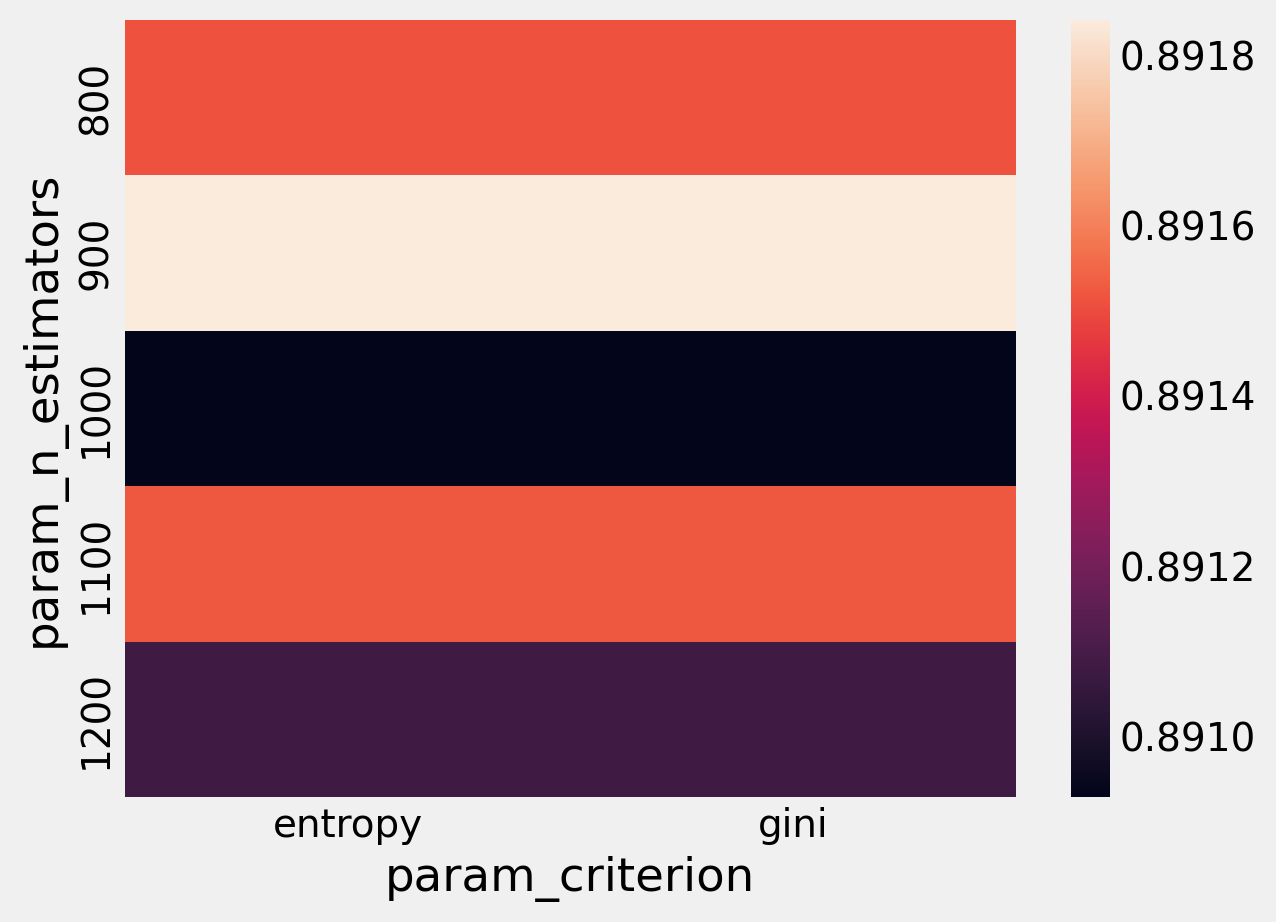

In [99]:
table = pd.pivot_table(pd.DataFrame(gs.cv_results_),
    values='mean_test_score', index='param_n_estimators',
                       columns='param_criterion')

sns.heatmap(table)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

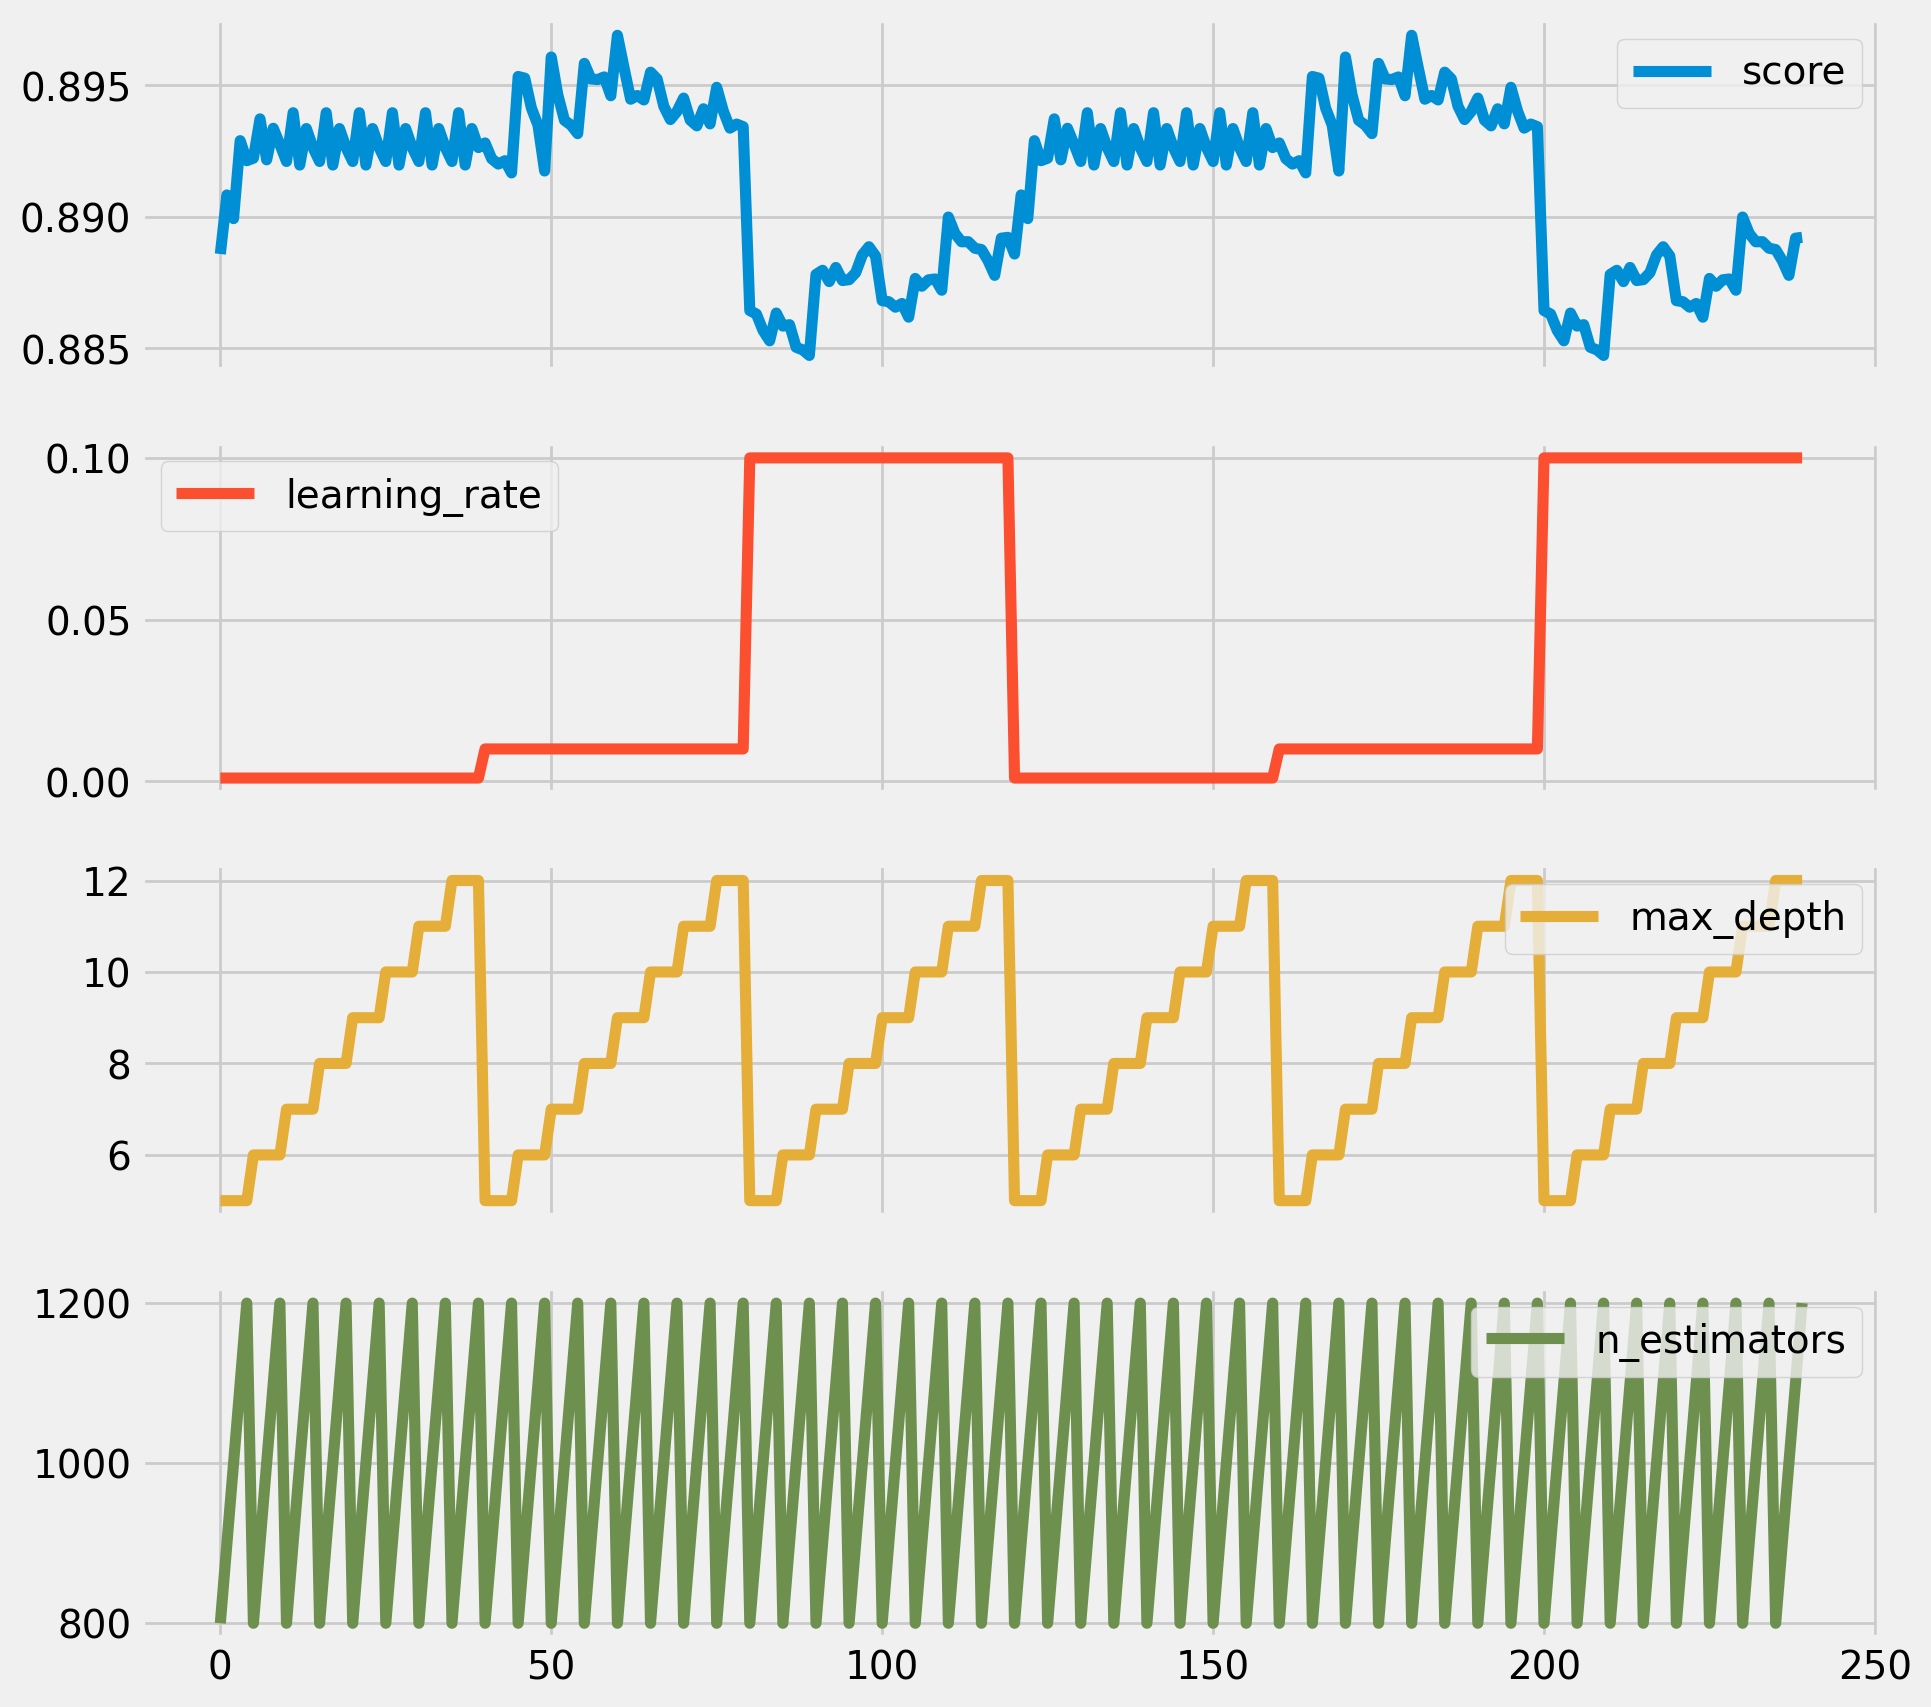

In [103]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_learning_rate'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                                        #  gs.cv_results_['param_min_samples_split'].data,
                                        #  gs.cv_results_['param_min_samples_leaf'].data,
                                        #  gs.cv_results_['param_max_leaf_nodes'].data,
                                        #  gs.cv_results_['param_min_impurity_split'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])#, 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes', 'min_impurity_split'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

In [104]:
from sklearn.model_selection import RandomizedSearchCV

In [114]:
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "criterion" : ["gini","entropy"], # 순수도 척도
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3),
    'min_samples_split' : np.linspace(0.1, 1.0, 10, dtype = float),
    'min_samples_leaf' : np.linspace(1, 5, 5, dtype = int),
    'max_leaf_nodes' : [None, 5, 10, 20],
    'min_impurity_split' : [0.0, 0.0001, 0.0005, 0.001]
    # "verbose" : [-1] # warning 제거
}
model = LGBMClassifier(random_state=args.random_state)

rs=RandomizedSearchCV(model, hp, scoring='roc_auc', n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False).fit(X_tr,y_tr)
rs.best_score_, rs.score(X_te,y_te)

[LightGBM] [Warning] Unknown parameter: min_impurity_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_impurity_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 242, number of negative: 399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 641, number of used features: 38
[LightGBM] [Info]

(0.9001212621577273, 0.8807073774179037)

In [115]:
pred = rs.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

[LightGBM] [Warning] Unknown parameter: min_impurity_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split


0.8807073774179037

In [116]:
pred = rs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[LightGBM] [Warning] Unknown parameter: min_impurity_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[[144  27]
 [ 18  86]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       171
           1       0.76      0.83      0.79       104

    accuracy                           0.84       275
   macro avg       0.82      0.83      0.83       275
weighted avg       0.84      0.84      0.84       275



<Axes: xlabel='param_criterion', ylabel='param_n_estimators'>

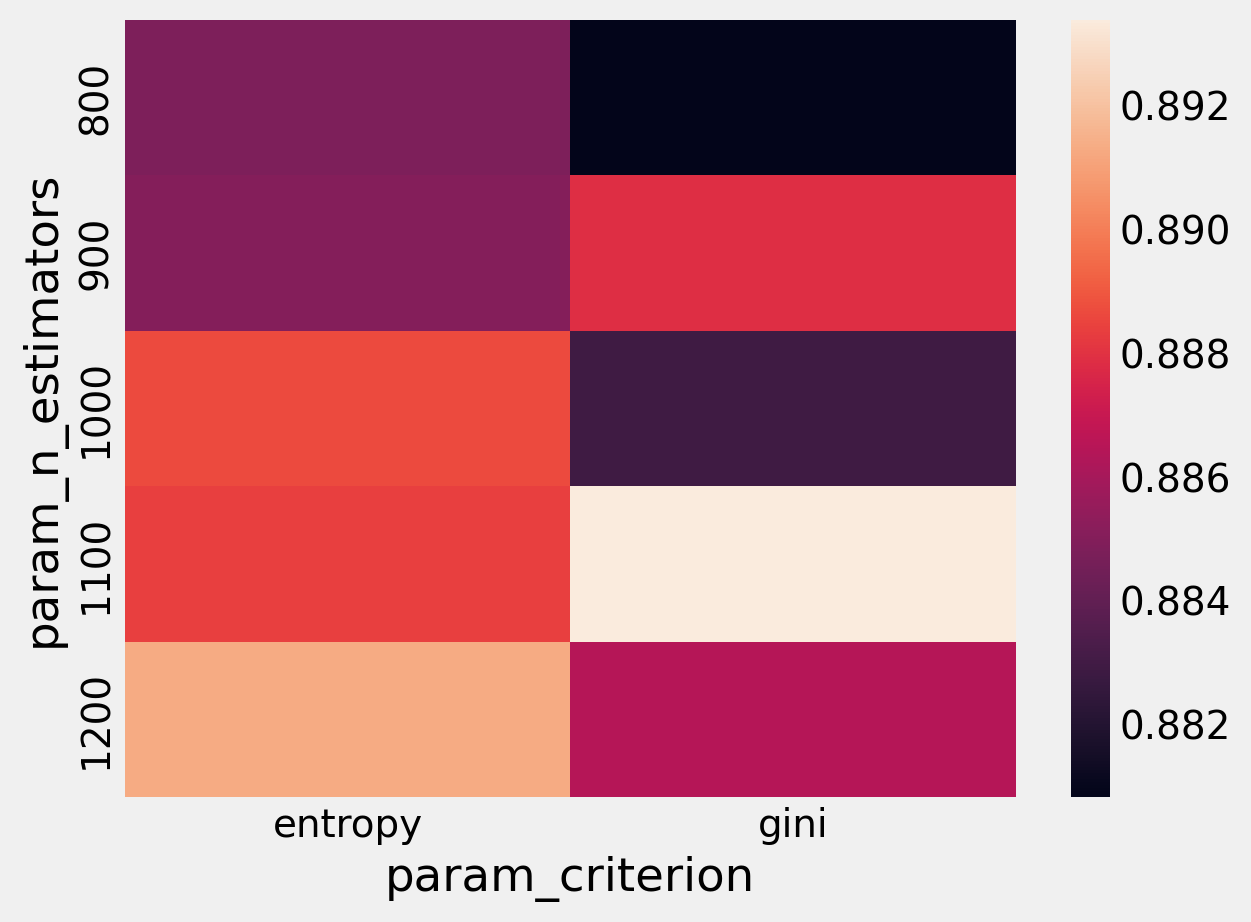

In [117]:
table = pd.pivot_table(pd.DataFrame(rs.cv_results_),
    values='mean_test_score', index='param_n_estimators',
                       columns='param_criterion')

sns.heatmap(table)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

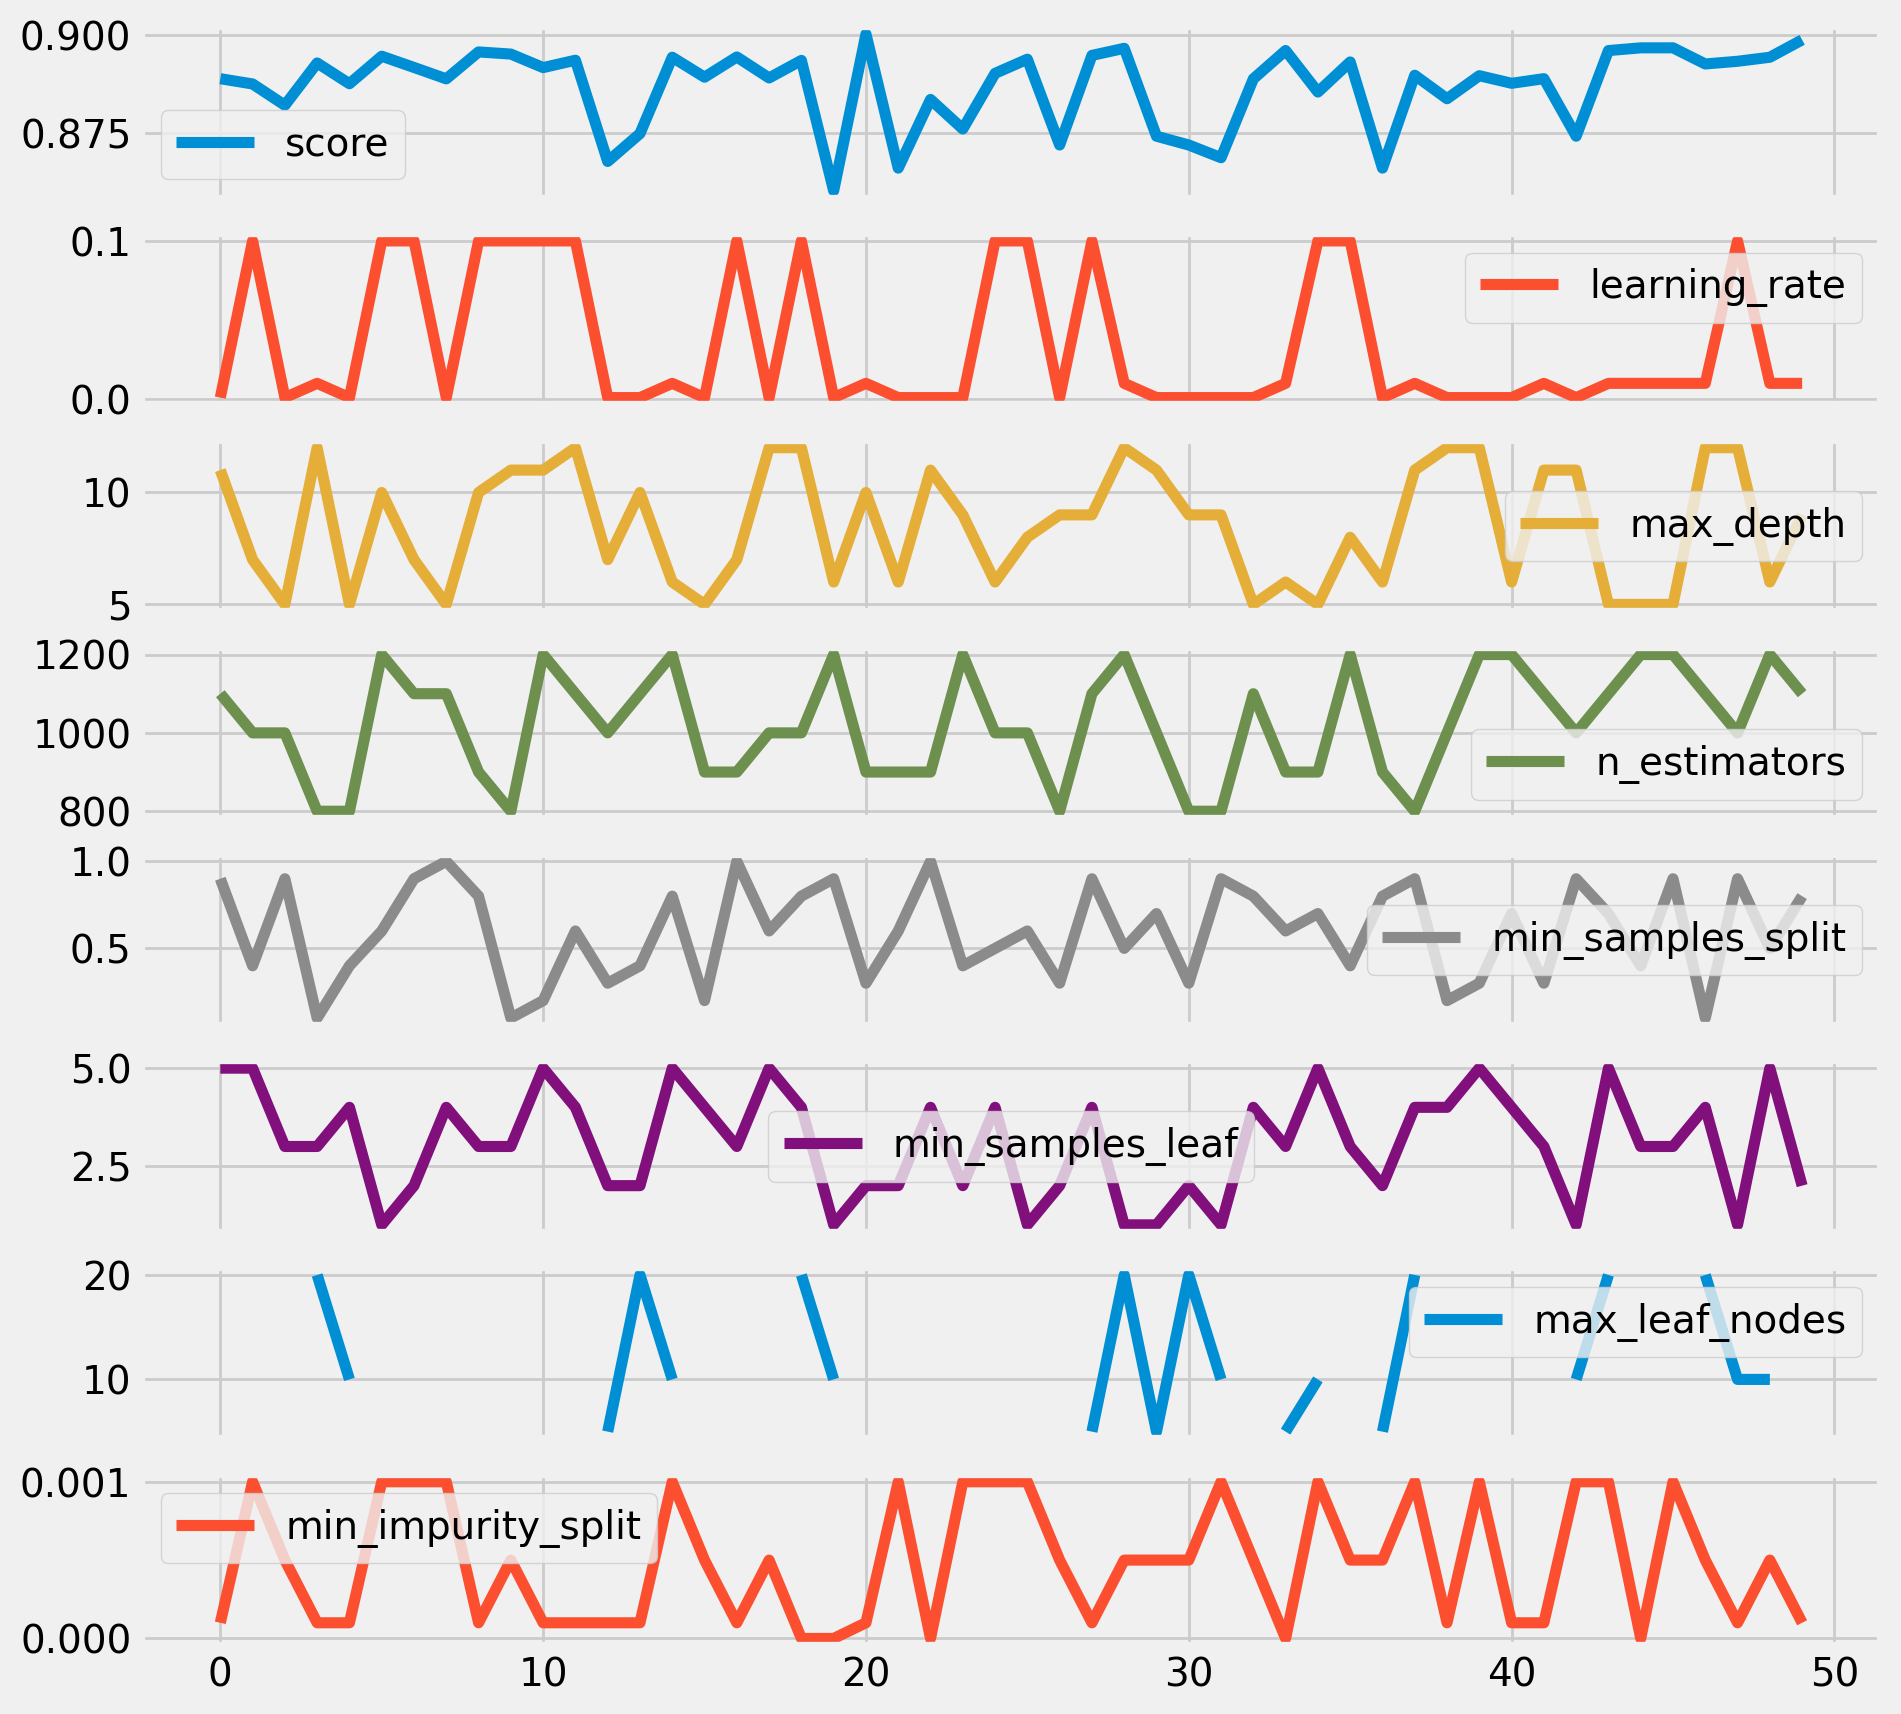

In [120]:
rs_results_df=pd.DataFrame(np.transpose([rs.cv_results_['mean_test_score'],
                                         rs.cv_results_['param_learning_rate'].data,
                                         rs.cv_results_['param_max_depth'].data,
                                         rs.cv_results_['param_n_estimators'].data,
                                         rs.cv_results_['param_min_samples_split'].data,
                                         rs.cv_results_['param_min_samples_leaf'].data,
                                         rs.cv_results_['param_max_leaf_nodes'].data,
                                         rs.cv_results_['param_min_impurity_split'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes', 'min_impurity_split'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

Text(0, 0.5, 'best_cumulative_score')

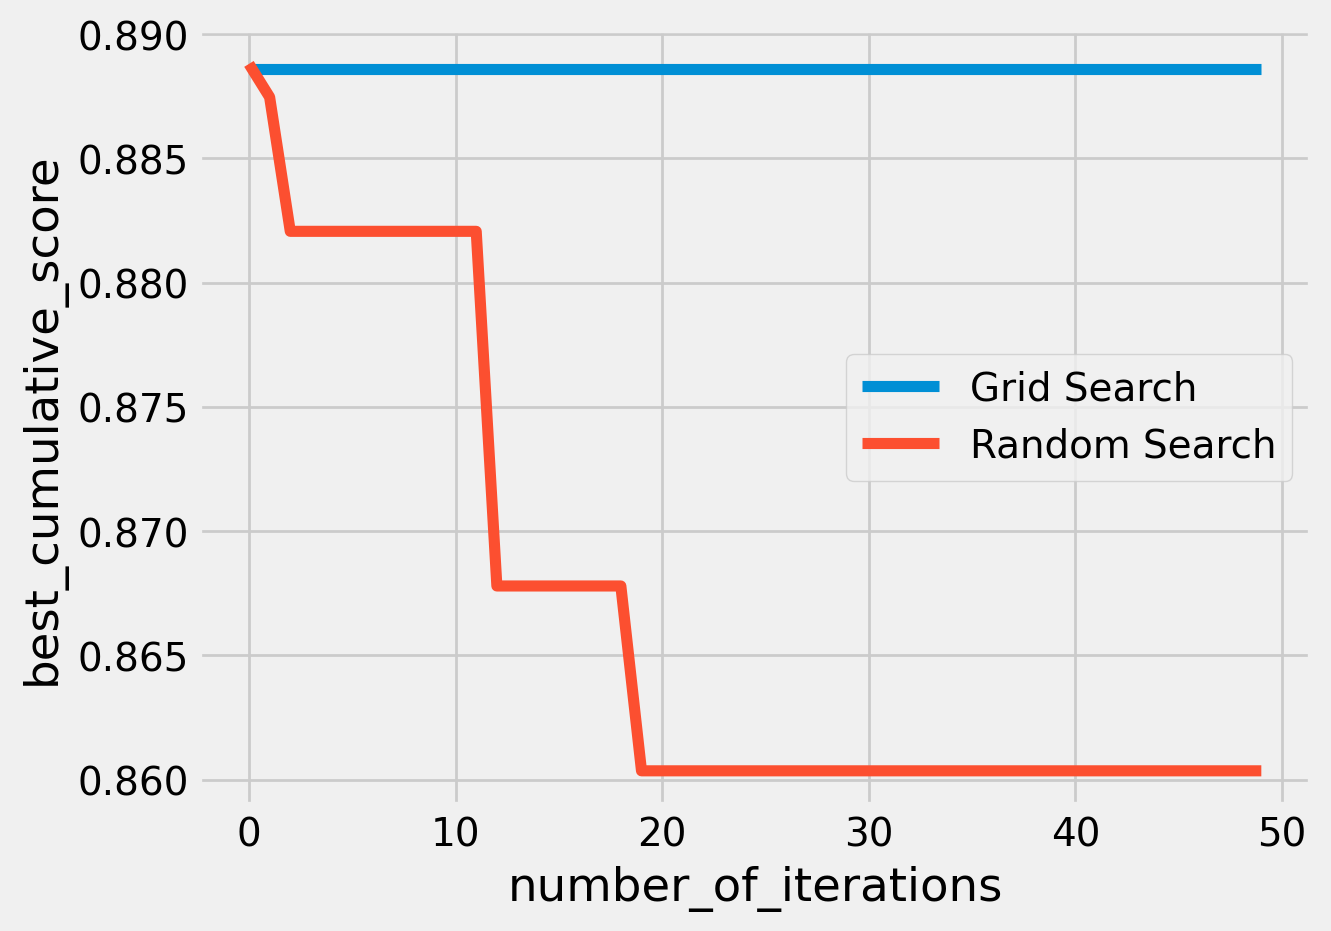

In [121]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()

ax = scores_df.plot()
ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

In [77]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [78]:
train.shape, test.shape, ori_te.shape

((641, 39), (275, 39), (393, 38))

In [79]:
# y_tr = train['survived']
# X_tr = train.drop(['survived'], axis=1)

# y_te = test['survived']
# X_te = test.drop(['survived'], axis=1)

# X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [80]:
# from sklearn.tree import DecisionTreeClassifier

In [81]:
# modelV4 = DecisionTreeClassifier(random_state=args.random_state)

# modelV4.fit(X_tr, y_tr)

In [82]:
from pycaret.classification import *

exp_clf = setup(data = train, target = 'survived', session_id=args.random_state)

In [83]:
best_model = compare_models()

Processing:   0%|          | 0/69 [00:00<?, ?it/s]

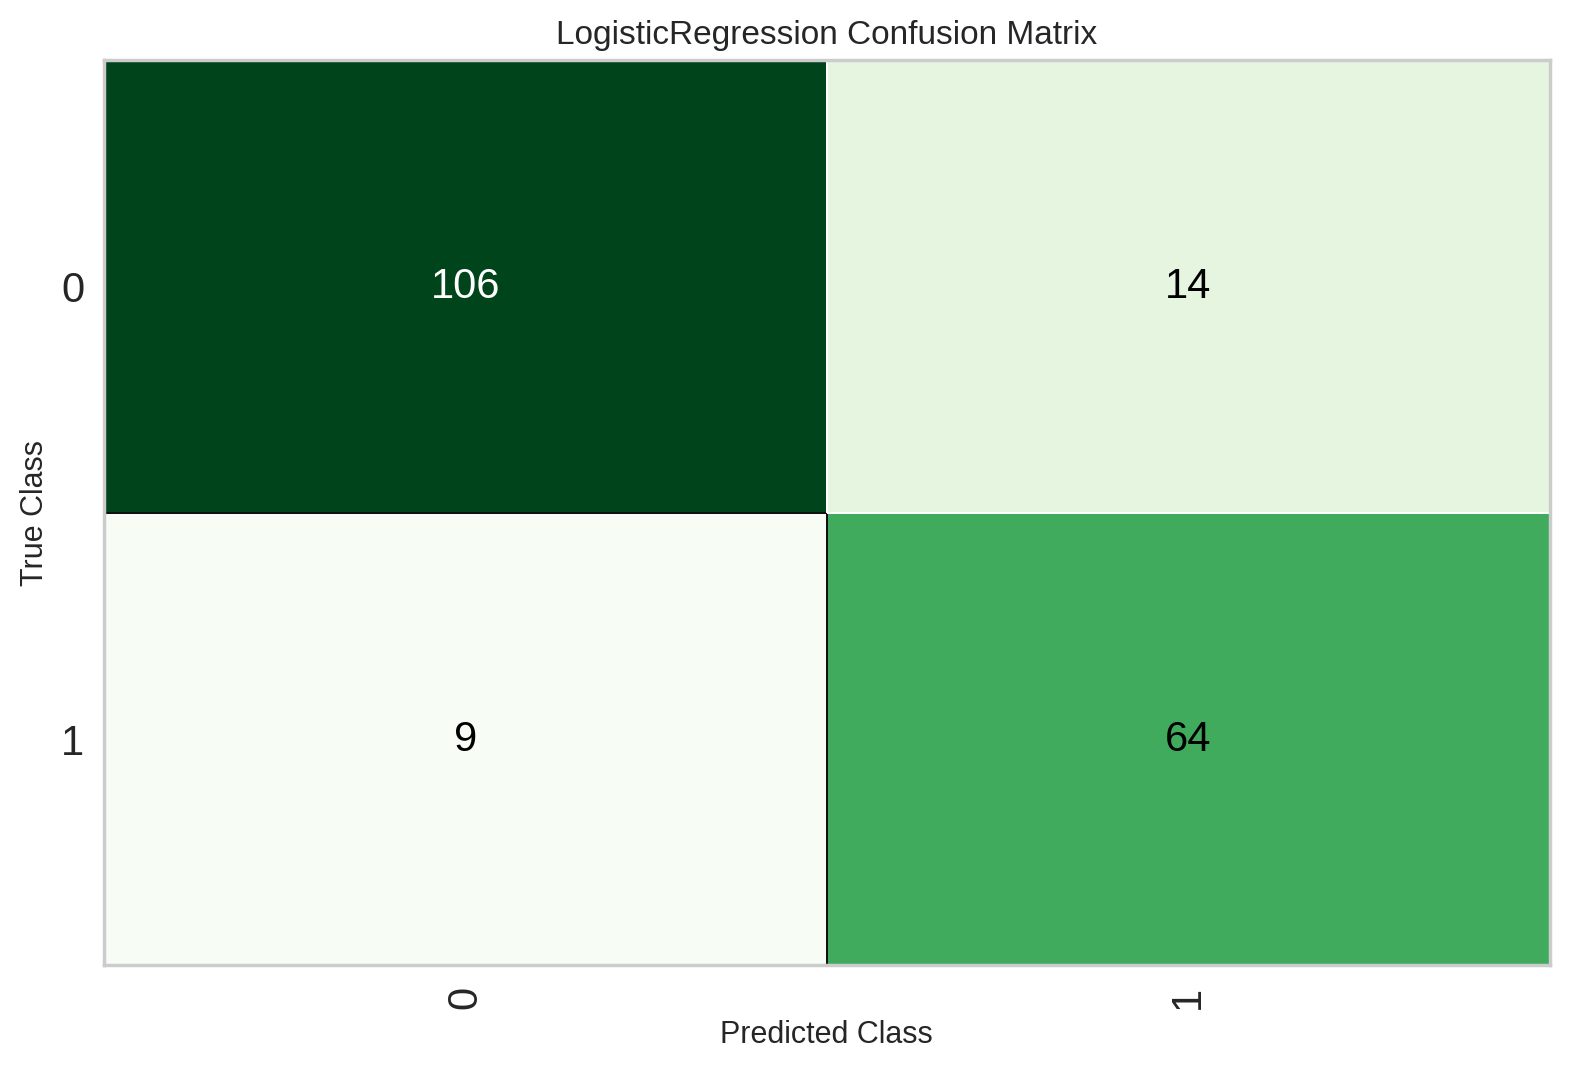

In [84]:
# plot confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

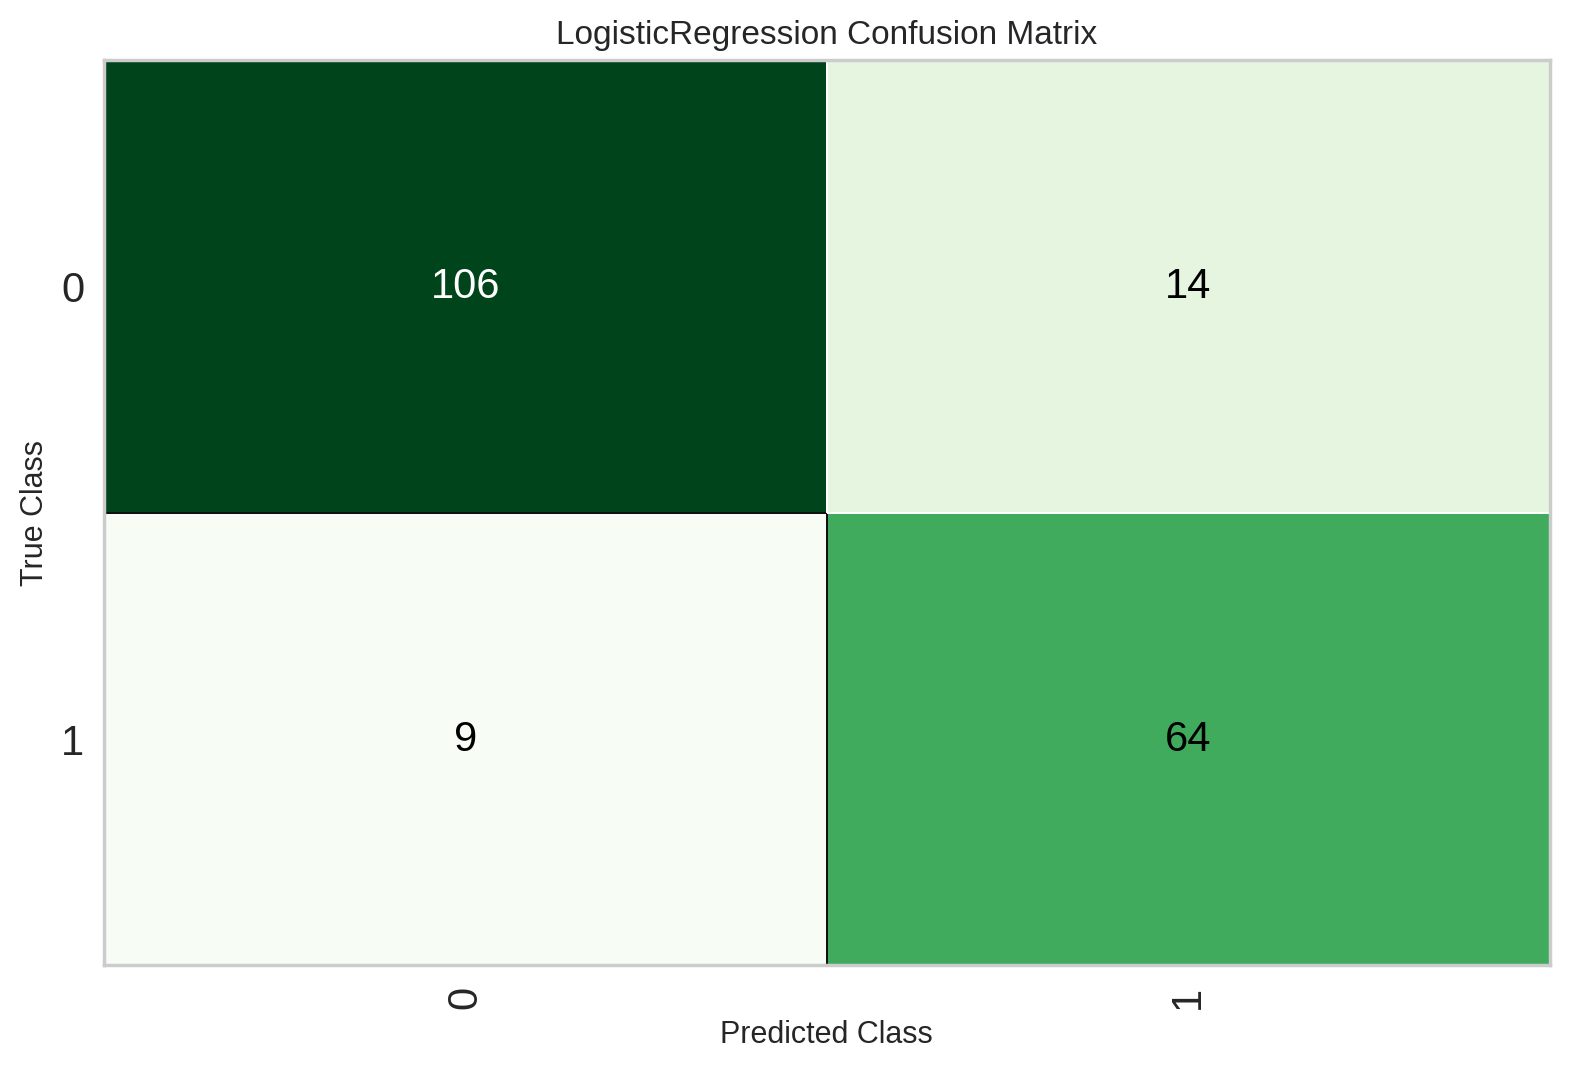

In [85]:
# plot confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

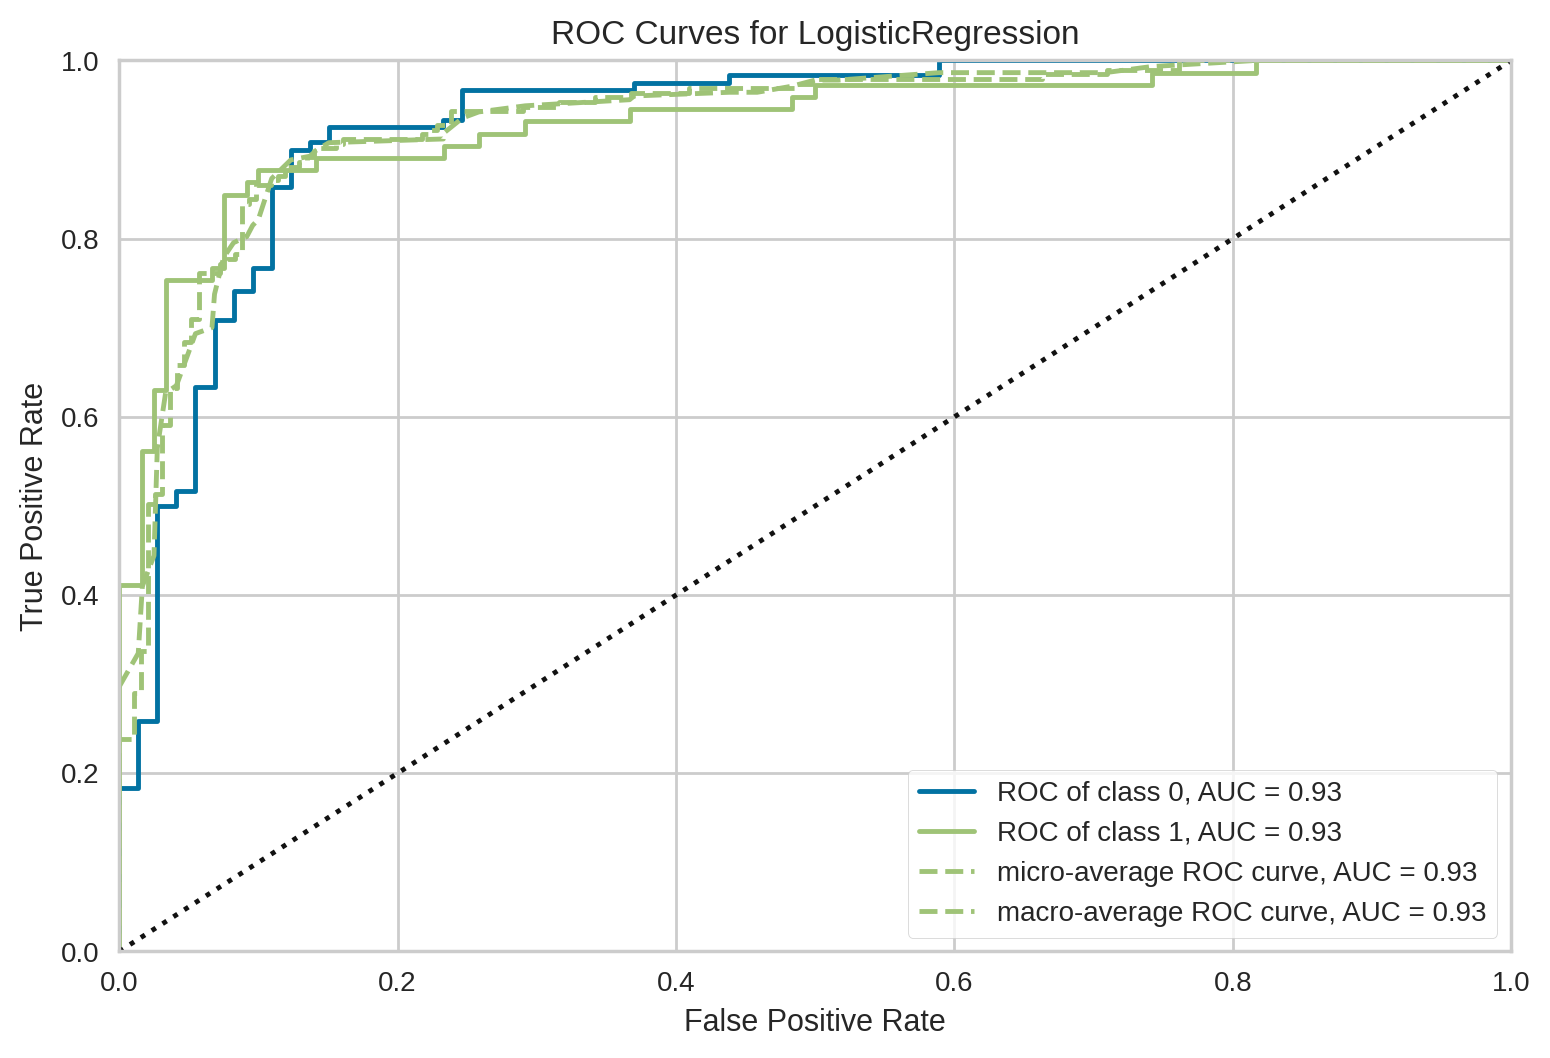

In [86]:
# plot AUC
plot_model(best_model, plot = 'auc')

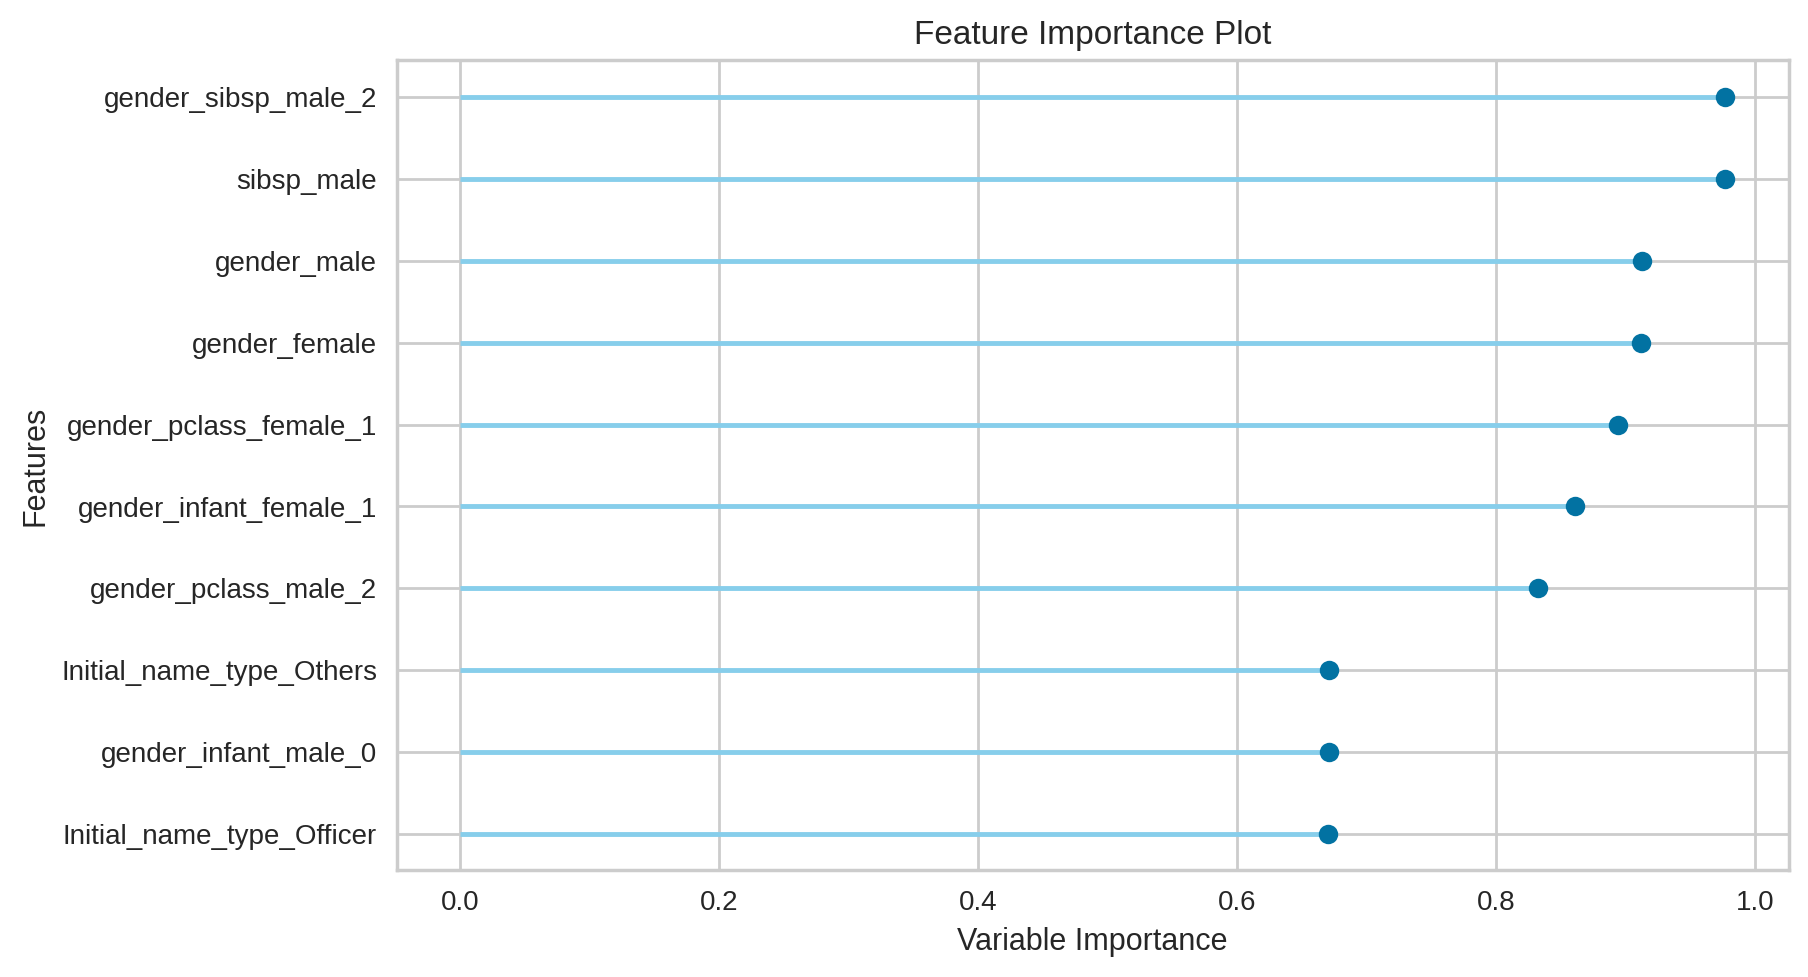

In [87]:
# plot feature importance
plot_model(best_model, plot = 'feature')

In [88]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [89]:
# predict on test set
holdout_pred = predict_model(best_model)

In [90]:
# show predictions df
holdout_pred.head()

len_ticket  reversed_pclass  sibsp_male  infant  pclass  sibsp  parch  \
151           1                1           0       0       3      0      0   
75            1                1           0       1       3      0      1   
473           1                1           0       0       3      0      0   
370           1                2           0       0       2      0      0   
545           1                1           0       0       3      0      0   

     age_cleaning  fare_cleaning  parch_male  ...  gender_sibsp_male_2  \
151     -0.130136      -0.477160           0  ...                  0.0   
75      -1.999109      -0.480349           0  ...                  0.0   
473     -0.061348      -0.477515           0  ...                  0.0   
370      0.557745      -0.402743           0  ...                  0.0   
545     -0.405289      -0.507990           0  ...                  0.0   

     gender_pclass_female_1  gender_pclass_female_2  gender_pclass_female_3  \
151                     0.0                     0.0                     0.0   
75                      0.0                     0.0                     0.0   
473                     0.0                     0.0                     0.0   
370                     0.0                     1.0                     0.0   
545                     0.0                     0.0                     0.0   

     gender_pclass_male_1  gender_pclass_male_2  gender_pclass_male_3  \
151                   0.0                   0.0                   1.0   
75                    0.0                   0.0                   1.0   
473                   0.0                   0.0                   1.0   
370                   0.0                   0.0                   0.0   
545                   0.0                   0.0                   1.0   

     survived  prediction_label  prediction_score  
151         0                 0            0.9094  
75          0                 1            0.5544  
473         0                 0            0.9102  
370         0                 1            0.9355  
545         0                 0            0.9064  

[5 rows x 41 columns]

In [91]:
# predict model on new_data
predictions = predict_model(best_model, data = test)
predictions.head()

len_ticket  reversed_pclass  sibsp_male  infant  pclass  sibsp  parch  \
0           1                3           0       0       1      1      0   
1           2                1           1       0       3      8      2   
2           2                3           0       0       1      2      2   
3           3                1           0       0       3      0      0   
4           1                1           0       0       3      1      0   

   age_cleaning  fare_cleaning  parch_male  ...  gender_sibsp_male_2  \
0      0.901685      -0.089747           0  ...                  0.0   
1      0.351381       0.799630           0  ...                  1.0   
2     -0.818017       4.899498           0  ...                  0.0   
3      0.970473      -0.510648           0  ...                  0.0   
4     -0.267712      -0.542275           0  ...                  0.0   

   gender_pclass_female_1  gender_pclass_female_2  gender_pclass_female_3  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     1.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   gender_pclass_male_1  gender_pclass_male_2  gender_pclass_male_3  survived  \
0                   1.0                   0.0                   0.0         0   
1                   0.0                   0.0                   1.0         0   
2                   0.0                   0.0                   0.0         1   
3                   0.0                   0.0                   1.0         1   
4                   0.0                   0.0                   1.0         0   

   prediction_label  prediction_score  
0                 0            0.7515  
1                 0            0.9963  
2                 1            0.9845  
3                 0            0.8958  
4                 0            0.8423  

[5 rows x 41 columns]

## Evaluation

In [92]:
# score_tr = modelV4.score(X_tr, y_tr)
# score_te = modelV4.score(X_te, y_te)

# score_tr, score_te

In [93]:
# from sklearn.metrics import roc_curve, auc

# y_pred = modelV4.predict_proba(X_te)[:,1]
# fpr, tpr, thresholds = roc_curve(y_te,y_pred)
# auc_te = auc(fpr, tpr)
# print(f'model: {auc_te}')

In [94]:
# X_tr.columns, ori_te.columns, X_te.columns

In [95]:
# ori_te_pred = modelV4.predict_proba(ori_te)[:,1]
# ori_te_pred.shape

In [96]:
# df_feature_importances = pd.DataFrame(modelV4.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

# print(f'{df_feature_importances.shape}')
# df_feature_importances

In [97]:
# args.results.append(
#     {
#         'model': 'modelV7',
#         'score_tr': score_tr,
#         'score_te': score_te,
#         'auc_te': auc_te,
#         'ori_te_pred': ori_te_pred,
#         'len_features': X_tr.shape[1],
#         'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
#         'create_dt': '0220'
#     }
# )

In [98]:
# pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

# Submission

In [99]:
# df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
# df_results

In [100]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

passengerid  survived
0          916       0.5
1          917       0.5
2          918       0.5
3          919       0.5
4          920       0.5

In [107]:
predictions.head()

len_ticket  reversed_pclass  sibsp_male  infant  pclass  sibsp  parch  \
0           1                3           0       0       1      1      0   
1           2                1           1       0       3      8      2   
2           2                3           0       0       1      2      2   
3           3                1           0       0       3      0      0   
4           1                1           0       0       3      1      0   

   age_cleaning  fare_cleaning  parch_male  ...  gender_sibsp_male_2  \
0      0.901685      -0.089747           0  ...                  0.0   
1      0.351381       0.799630           0  ...                  1.0   
2     -0.818017       4.899498           0  ...                  0.0   
3      0.970473      -0.510648           0  ...                  0.0   
4     -0.267712      -0.542275           0  ...                  0.0   

   gender_pclass_female_1  gender_pclass_female_2  gender_pclass_female_3  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     1.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   gender_pclass_male_1  gender_pclass_male_2  gender_pclass_male_3  survived  \
0                   1.0                   0.0                   0.0         0   
1                   0.0                   0.0                   1.0         0   
2                   0.0                   0.0                   0.0         1   
3                   0.0                   0.0                   1.0         1   
4                   0.0                   0.0                   1.0         0   

   prediction_label  prediction_score  
0                 0            0.7515  
1                 0            0.9963  
2                 1            0.9845  
3                 0            0.8958  
4                 0            0.8423  

[5 rows x 41 columns]

In [110]:
args.results.append(
    {
        'model': 'modelV7',
        # 'score_tr': score_tr,
        # 'score_te': score_te,
        # 'auc_te': auc_te,
        'ori_te_pred': predictions['prediction_score'],
        # 'len_features': X_tr.shape[1],
        # 'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0220'
    }
)

In [ ]:
# pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

In [112]:
args.results

[{'model': 'modelV4',
  'score_tr': 0.9547581903,
  'score_te': 0.8327272727,
  'auc_te': 0.916020018,
  'len_features': 10,
  'feaute_importances': ['fare',
   'age',
   'sibsp',
   'pclass',
   'embarked_S',
   'gender_female',
   'parch',
   'embarked_C',
   'embarked_Q',
   'gender_male'],
  'create_dt': '0217'},
 {'model': 'modelV7',
  'ori_te_pred': 0      0.7515
  1      0.9963
  2      0.9845
  3      0.8958
  4      0.8423
          ...  
  270    0.6839
  271    0.8921
  272    0.8486
  273    0.9339
  274    0.8696
  Name: prediction_score, Length: 275, dtype: float64,
  'create_dt': '0220'}]

In [119]:
args.results[1]['ori_te_pred'].values[0]

0.7515

In [120]:
submission['survived'] = args.results[1]['ori_te_pred']
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

118


passengerid  survived
0          916    0.7515
1          917    0.9963
2          918    0.9845
3          919    0.8958
4          920    0.8423
5          921    0.9925
6          922    0.9235
7          923    0.9485
8          924    0.8926
9          925    0.8851

In [122]:
submission.tail(10)

passengerid  survived
383         1299       NaN
384         1300       NaN
385         1301       NaN
386         1302       NaN
387         1303       NaN
388         1304       NaN
389         1305       NaN
390         1306       NaN
391         1307       NaN
392         1308       NaN

In [121]:
submission.to_csv(args.default_path+'result/submission_v7.csv', header=True, index=False)

In [105]:
submission['survived'] = df_results.loc[4, ['ori_te_pred']].values[0]
submission.to_csv(args.default_path+'result/submission_v4.csv', header=True, index=False)

NameError: name 'df_results' is not defined

# Save Results

In [ ]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True)
df_results

In [ ]:
df_results.to_json(args.save_results, orient="records")

In [ ]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

len(load_results)